# Replication of results of the article

(c) Charles Le Losq and contributors, 2021-2023
see embedded licence file

This notebook generates figures and values to assess the final performance fo the 10 selected models.

## Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern#, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# for uncertainty calibration
from fortuna.conformal.regression import QuantileConformalRegressor

# neuravi internals
import src.imelt as imelt
import src.utils as utils

# other essentials
import torch
import time 
import h5py

# we will work on GPU or CPU there, depending on availability
device = utils.get_default_device()

# fixing random seed for reproductible results in this notebook
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

CUDA AVAILABLE? 
No, setting device to cpu


# Loading dataset and models

In [2]:
#
# data are loaded using the data_loader helper.
#
ds = imelt.data_loader()

#
# The 10 models are loaded through a bagging class.
#
neuralmodel = imelt.load_pretrained_bagged()

#
# Print information about dataset
#
ds.print_data()

################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 790
Number of unique compositions in training (viscosity): 634
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (entropy): 99
Number of unique compositions in training (entropy): 79
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (refractive index): 610
Number of unique compositions in training (refractive index): 492
Dataset separations are 0.81 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (glass density): 668
Number of unique compositions in training (glass density): 535
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (glass elastic modulus): 1006
Number of unique compositions in training (glass elastic modulus): 808
Dataset separations are 0.80 in train, 0.10 in valid, 0.1

# Figure 1

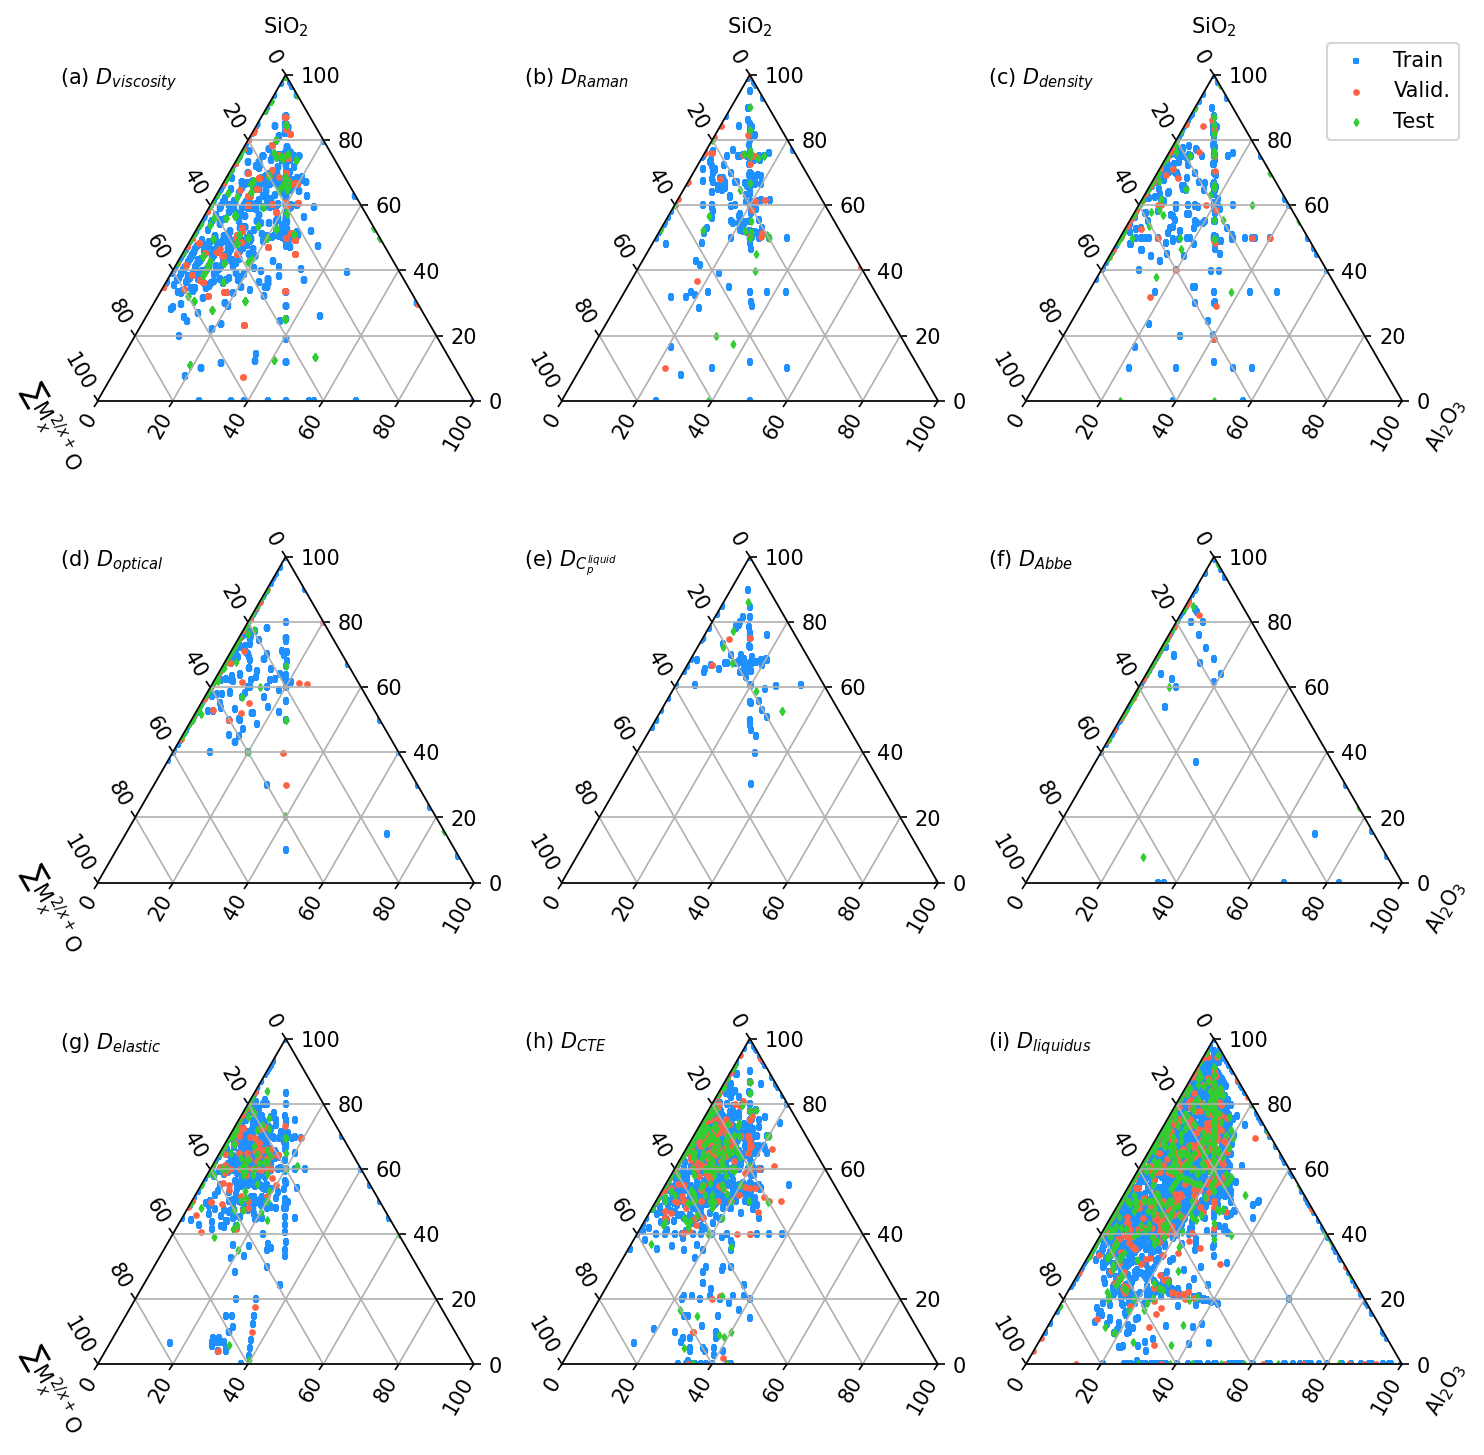

In [3]:
marker_size = 5
plt.figure(figsize=(10,10),dpi=150)

colors = ['dodgerblue', 'tomato', 'limegreen']
ax1 = plt.subplot(3,3,1,projection='ternary',ternary_scale=100)
ax2 = plt.subplot(3,3,2,projection='ternary',ternary_scale=100)
ax3 = plt.subplot(3,3,3,projection='ternary',ternary_scale=100)
ax4 = plt.subplot(3,3,4,projection='ternary',ternary_scale=100)
ax5 = plt.subplot(3,3,5,projection='ternary',ternary_scale=100)
ax6 = plt.subplot(3,3,6,projection='ternary',ternary_scale=100)
ax7 = plt.subplot(3,3,7,projection='ternary',ternary_scale=100)
ax8 = plt.subplot(3,3,8,projection='ternary',ternary_scale=100)
ax9 = plt.subplot(3,3,9,projection='ternary',ternary_scale=100)

# The data
ax1.scatter(ds.x_visco_train.detach().numpy()[:,0], ds.x_visco_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_visco_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Train data subset")
ax1.scatter(ds.x_visco_valid.detach().numpy()[:,0], ds.x_visco_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_visco_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation data subset")
ax1.scatter(ds.x_visco_test.detach().numpy()[:,0], ds.x_visco_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_visco_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing data subset")

ax2.scatter(ds.x_raman_train.detach().numpy()[:,0], ds.x_raman_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_raman_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Ent.")
ax2.scatter(ds.x_raman_valid.detach().numpy()[:,0], ds.x_raman_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_raman_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Valid.")
ax2.scatter(ds.x_raman_test.detach().numpy()[:,0], ds.x_raman_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_raman_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Test.")

ax3.scatter(ds.x_density_train.detach().numpy()[:,0], ds.x_density_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_density_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Train")
ax3.scatter(ds.x_density_valid.detach().numpy()[:,0], ds.x_density_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_density_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Valid.")
ax3.scatter(ds.x_density_test.detach().numpy()[:,0], ds.x_density_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_density_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Test")

ax4.scatter(ds.x_ri_train.detach().numpy()[:,0], ds.x_ri_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_ri_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Ent.")
ax4.scatter(ds.x_ri_valid.detach().numpy()[:,0], ds.x_ri_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_ri_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Valid.")
ax4.scatter(ds.x_ri_test.detach().numpy()[:,0], ds.x_ri_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_ri_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Test")

ax5.scatter(ds.x_cpl_train.detach().numpy()[:,0], ds.x_cpl_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_cpl_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax5.scatter(ds.x_cpl_valid.detach().numpy()[:,0], ds.x_cpl_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_cpl_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax5.scatter(ds.x_cpl_test.detach().numpy()[:,0], ds.x_cpl_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_cpl_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax6.scatter(ds.x_abbe_train.detach().numpy()[:,0], ds.x_abbe_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_abbe_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax6.scatter(ds.x_abbe_valid.detach().numpy()[:,0], ds.x_abbe_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_abbe_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax6.scatter(ds.x_abbe_test.detach().numpy()[:,0], ds.x_abbe_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_abbe_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax7.scatter(ds.x_elastic_train.detach().numpy()[:,0], ds.x_elastic_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_elastic_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax7.scatter(ds.x_elastic_valid.detach().numpy()[:,0], ds.x_elastic_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_elastic_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax7.scatter(ds.x_elastic_test.detach().numpy()[:,0], ds.x_elastic_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_elastic_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax8.scatter(ds.x_cte_train.detach().numpy()[:,0], ds.x_cte_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_cte_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax8.scatter(ds.x_cte_valid.detach().numpy()[:,0], ds.x_cte_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_cte_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax8.scatter(ds.x_cte_test.detach().numpy()[:,0], ds.x_cte_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_cte_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

ax9.scatter(ds.x_liquidus_train.detach().numpy()[:,0], ds.x_liquidus_train.detach().numpy()[:,2:6].sum(axis=1), ds.x_liquidus_train.detach().numpy()[:,1],
            marker='s', s=marker_size, color=colors[0], alpha=1., label="Training")
ax9.scatter(ds.x_liquidus_valid.detach().numpy()[:,0], ds.x_liquidus_valid.detach().numpy()[:,2:6].sum(axis=1), ds.x_liquidus_valid.detach().numpy()[:,1],
            marker='o', s=marker_size, color=colors[1], alpha=1., label="Validation")
ax9.scatter(ds.x_liquidus_test.detach().numpy()[:,0], ds.x_liquidus_test.detach().numpy()[:,2:6].sum(axis=1), ds.x_liquidus_test.detach().numpy()[:,1],
            marker='d', s=marker_size, color=colors[2], alpha=1., label="Testing")

# add grid
for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    i.grid(axis='t')
    i.grid(axis='l')
    i.grid(axis='r')

# label axis
for i in [ax1, ax2, ax3]:
    i.set_tlabel('SiO$_2$')

for i in [ax1, ax4, ax7]:
    i.set_llabel('$\sum$M$^{2/x+}_{x}$O')

for i in [ax3, ax6, ax9]:
    i.set_rlabel('Al$_2$O$_3$')

# annotation of the subplots
ax1.annotate("(a) $D_{viscosity}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax2.annotate("(b) $D_{Raman}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax3.annotate("(c) $D_{density}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax4.annotate("(d) $D_{optical}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax5.annotate("(e) $D_{C_{p}^{liquid}}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax6.annotate("(f) $D_{Abbe}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax7.annotate("(g) $D_{elastic}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax8.annotate("(h) $D_{CTE}$",xy=(-0.1,0.97),xycoords="axes fraction")
ax9.annotate("(i) $D_{liquidus}$",xy=(-0.1,0.97),xycoords="axes fraction")

# output things
plt.tight_layout()
ax3.legend(loc=(0.8,0.8),fontsize=10)

plt.savefig("./figures/manuscript/Figure1.pdf")

# Figure 2

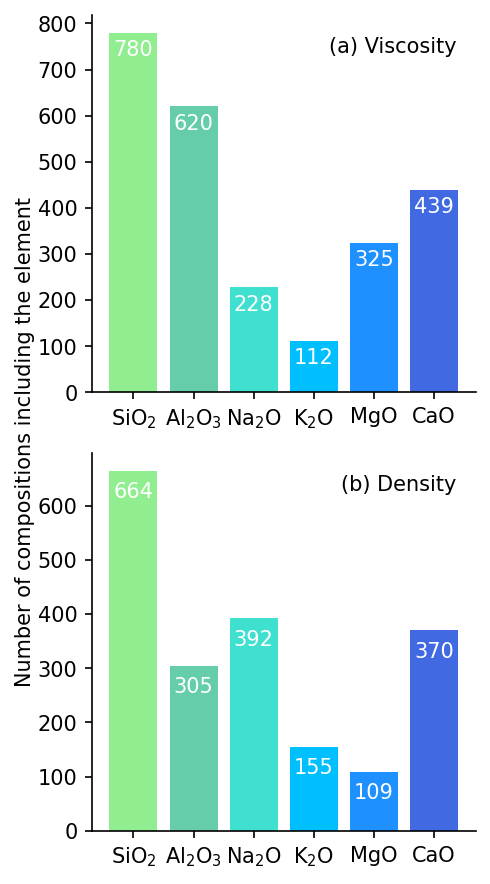

In [4]:
###
# # Quantity of each chemical component in the datasets of viscosity and density
###

# get full chemical sets
x_visco = torch.cat((ds.x_visco_train, ds.x_visco_valid, ds.x_visco_test)).unique(dim=0)
x_density = torch.cat((ds.x_density_train, ds.x_density_valid, ds.x_density_test)).unique(dim=0)

# lists to count things
nb_visco = []
nb_density = []

# loop for counting
for i in range(6):
    nb_visco.append(len(np.where(x_visco[:,i]!=0)[0]))
    nb_density.append(len(np.where(x_density[:,i]!=0)[0]))
    
#
# make figure
#
fig = plt.figure(figsize=(3.22,6), dpi=150)

colors=['lightgreen', 'mediumaquamarine', 'turquoise', 'deepskyblue', 'dodgerblue', 'royalblue']

#
# first subplot
#
ax = plt.subplot(211)
plt.bar(range(0,6),nb_visco, tick_label=['SiO$_2$', 'Al$_2$O$_3$', 'Na$_2$O', 'K$_2$O', 'MgO', 'CaO'],color=colors)
plt.annotate("(a) Viscosity",xy=(0.95,0.9),xycoords="axes fraction",ha="right")
for count,i in enumerate(nb_visco):
    plt.annotate(str(i),xy=(count,i-50),xycoords="data",color='w', ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#
# second subplot
#
ax = plt.subplot(212)
plt.bar(range(0,6),nb_density, tick_label=['SiO$_2$', 'Al$_2$O$_3$', 'Na$_2$O', 'K$_2$O', 'MgO', 'CaO'],color=colors)
plt.annotate("(b) Density",xy=(0.95,0.9),xycoords="axes fraction",ha="right")
for count,i in enumerate(nb_density):
    plt.annotate(str(i),xy=(count,i-50),xycoords="data",color='w', ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.text(0.0, 0.5, "Number of compositions including the element", va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("./figures/manuscript/Figure2.pdf")


# Root-mean-squared-errors calculations

Between all datasets and their predictions.

In [5]:
RMSE_ag_tot, RMSE_ag_low, RMSE_ag_high = utils.error_viscosity_bydomain(neuralmodel, ds, method='ag', boundary=7, mode="RMSE")
MAE_ag_tot, MAE_ag_low, MAE_ag_high = utils.error_viscosity_bydomain(neuralmodel, ds, method='ag', boundary=7, mode="MAE")

RMSE_cg_tot, RMSE_cg_low, RMSE_cg_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='cg', boundary=7)
MAE_cg_tot, MAE_cg_low, MAE_cg_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='cg', boundary=7, mode="MAE")

RMSE_tvf_tot, RMSE_tvf_low, RMSE_tvf_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='tvf', boundary=7)
MAE_tvf_tot, MAE_tvf_low, MAE_tvf_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='tvf', boundary=7, mode="MAE")

RMSE_am_tot, RMSE_am_low, RMSE_am_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='am', boundary=7)
MAE_am_tot, MAE_am_low, MAE_am_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='am', boundary=7, mode="MAE")

RMSE_myega_tot, RMSE_myega_low, RMSE_myega_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='myega', boundary=7)
MAE_myega_tot, MAE_myega_low, MAE_myega_high = utils.error_viscosity_bydomain(neuralmodel,ds,method='myega', boundary=7, mode="MAE")


RMSE using the equation from Adam-Gibbs:
     on the full range (0-15 log Pa s): train 0.24, valid 0.32, test 0.38
     on the -inf - 7.0 log Pa s range: train 0.18, valid 0.24, test 0.23
     on the 7.0 - +inf log Pa s range: train 0.31, valid 0.42, test 0.59

MAE using the equation from Adam-Gibbs:
     on the full range (0-15 log Pa s): train 0.12, valid 0.14, test 0.15
     on the -inf - 7.0 log Pa s range: train 0.09, valid 0.11, test 0.10
     on the 7.0 - +inf log Pa s range: train 0.17, valid 0.24, test 0.33

RMSE using the equation from Free Volume:
     on the full range (0-15 log Pa s): train 0.22, valid 0.24, test 0.32
     on the -inf - 7.0 log Pa s range: train 0.16, valid 0.18, test 0.22
     on the 7.0 - +inf log Pa s range: train 0.29, valid 0.31, test 0.47

MAE using the equation from Free Volume:
     on the full range (0-15 log Pa s): train 0.08, valid 0.08, test 0.11
     on the -inf - 7.0 log Pa s range: train 0.06, valid 0.05, test 0.09
     on the 7.0 - +inf log

In [6]:
# Now we calculate on density and refractive index
ese_density_train, mae_density_train = utils.residual_error_calc(ds.y_density_train, neuralmodel.predict("density_glass",ds.x_density_train))
ese_density_valid, mae_density_valid = utils.residual_error_calc(ds.y_density_valid, neuralmodel.predict("density_glass",ds.x_density_valid))
ese_density_test, mae_density_test = utils.residual_error_calc(ds.y_density_test, neuralmodel.predict("density_glass",ds.x_density_test))

ese_ri_train, mae_ri_train = utils.residual_error_calc(ds.y_ri_train, neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train))
ese_ri_valid, mae_ri_valid = utils.residual_error_calc(ds.y_ri_valid, neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid))
ese_ri_test, mae_ri_test = utils.residual_error_calc(ds.y_ri_test, neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test))

ese_abbe_train, mae_abbe_train = utils.residual_error_calc(ds.y_abbe_train, neuralmodel.predict("abbe",ds.x_abbe_train))
ese_abbe_valid, mae_abbe_valid = utils.residual_error_calc(ds.y_abbe_valid, neuralmodel.predict("abbe",ds.x_abbe_valid))
ese_abbe_test, mae_abbe_test = utils.residual_error_calc(ds.y_abbe_test, neuralmodel.predict("abbe",ds.x_abbe_test))

ese_liquidus_train, mae_liquidus_train = utils.residual_error_calc(ds.y_liquidus_train, neuralmodel.predict("liquidus",ds.x_liquidus_train))
ese_liquidus_valid, mae_liquidus_valid = utils.residual_error_calc(ds.y_liquidus_valid, neuralmodel.predict("liquidus",ds.x_liquidus_valid))
ese_liquidus_test, mae_liquidus_test = utils.residual_error_calc(ds.y_liquidus_test, neuralmodel.predict("liquidus",ds.x_liquidus_test))

ese_elastic_train, mae_elastic_train = utils.residual_error_calc(ds.y_elastic_train, neuralmodel.predict("elastic_modulus",ds.x_elastic_train))
ese_elastic_valid, mae_elastic_valid = utils.residual_error_calc(ds.y_elastic_valid, neuralmodel.predict("elastic_modulus",ds.x_elastic_valid))
ese_elastic_test, mae_elastic_test = utils.residual_error_calc(ds.y_elastic_test, neuralmodel.predict("elastic_modulus",ds.x_elastic_test))

ese_cte_train, mae_cte_train = utils.residual_error_calc(ds.y_cte_train, neuralmodel.predict("cte",ds.x_cte_train))
ese_cte_valid, mae_cte_valid = utils.residual_error_calc(ds.y_cte_valid, neuralmodel.predict("cte",ds.x_cte_valid))
ese_cte_test, mae_cte_test = utils.residual_error_calc(ds.y_cte_test, neuralmodel.predict("cte",ds.x_cte_test))

ese_tg_train, mae_tg_train = utils.residual_error_calc(ds.y_tg_train.cpu().detach().numpy(),
                           neuralmodel.predict("tg",ds.x_tg_train))
ese_tg_valid, mae_tg_valid = utils.residual_error_calc(ds.y_tg_valid.cpu().detach().numpy(),
                           neuralmodel.predict("tg",ds.x_tg_valid))
ese_tg_test, mae_tg_test = utils.residual_error_calc(ds.y_tg_test.cpu().detach().numpy(),
                           neuralmodel.predict("tg",ds.x_tg_test))

ese_entro_train, mae_entro_train = utils.residual_error_calc(ds.y_entro_train.cpu().detach().numpy(),
                                                             neuralmodel.predict("sctg",ds.x_entro_train))
ese_entro_valid, mae_entro_valid = utils.residual_error_calc(ds.y_entro_valid.cpu().detach().numpy(),
                                                             neuralmodel.predict("sctg",ds.x_entro_valid))
ese_entro_test, mae_entro_test = utils.residual_error_calc(ds.y_entro_test.cpu().detach().numpy(),
                                                           neuralmodel.predict("sctg",ds.x_entro_test))

ese_cpl_train, mae_cpl_train = utils.residual_error_calc(ds.y_cpl_train.cpu().detach().numpy(),
                                                         neuralmodel.predict("cpl",
                                                                             ds.x_cpl_train, T=ds.T_cpl_train))
ese_cpl_valid, mae_cpl_valid = utils.residual_error_calc(ds.y_cpl_valid.cpu().detach().numpy(),
                                                         neuralmodel.predict("cpl",
                                                                             ds.x_cpl_valid, T=ds.T_cpl_valid))
ese_cpl_test, mae_cpl_test = utils.residual_error_calc(ds.y_cpl_test.cpu().detach().numpy(),
                                                       neuralmodel.predict("cpl",
                                                                           ds.x_cpl_test, T=ds.T_cpl_test))

print('RMSE density train after training {0:.3f}'.format(ese_density_train))
print('RMSE density valid after training {0:.2f}'.format(ese_density_valid))
print('RMSE density test after training {0:.2f}'.format(ese_density_test))
print('')

print('RMSE refractive train loss after training {0:.3f}'.format(ese_ri_train))
print('RMSE refractive valid loss after training {0:.3f}'.format(ese_ri_valid))
print('RMSE refractive test loss after training {0:.3f}'.format(ese_ri_test))
print('')

print('RMSE liquidus train after training {0:.0f}'.format(ese_liquidus_train))
print('RMSE liquidus valid after training {0:.0f}'.format(ese_liquidus_valid))
print('RMSE liquidus test after training {0:.0f}'.format(ese_liquidus_test))
print('')

print('RMSE Abbe number train after training {0:.1f}'.format(ese_abbe_train))
print('RMSE Abbe number valid after training {0:.1f}'.format(ese_abbe_valid))
print('RMSE Abbe number test after training {0:.1f}'.format(ese_abbe_test))
print('')

print('RMSE Elastic Modulus train after training {0:.1f}'.format(ese_elastic_train))
print('RMSE Elastic Modulus valid after training {0:.1f}'.format(ese_elastic_valid))
print('RMSE Elastic Modulus test after training {0:.1f}'.format(ese_elastic_test))
print('')

print('RMSE CTE train after training {0:.1f}'.format(ese_cte_train))
print('RMSE CTE valid after training {0:.1f}'.format(ese_cte_valid))
print('RMSE CTE test after training {0:.1f}'.format(ese_cte_test))
print('')

print('RMSE Tg train after training {0:.1f}'.format(ese_tg_train))
print('RMSE Tg valid after training {0:.1f}'.format(ese_tg_valid))
print('RMSE Tg test after training {0:.1f}'.format(ese_tg_test))
print('')

print('RMSE Sc(Tg) train after training {0:.1f}'.format(ese_entro_train))
print('RMSE Sc(Tg) valid after training {0:.1f}'.format(ese_entro_valid))
print('RMSE Sc(Tg) test after training {0:.1f}'.format(ese_entro_test))
print('')

print('RMSE Cp of liquid at T train after training {0:.1f}'.format(ese_cpl_train))
print('RMSE Cp of liquid at T valid after training {0:.1f}'.format(ese_cpl_valid))
print('RMSE Cp of liquid at T test after training {0:.1f}'.format(ese_cpl_test))
print('')


RMSE density train after training 0.011
RMSE density valid after training 0.01
RMSE density test after training 0.02

RMSE refractive train loss after training 0.003
RMSE refractive valid loss after training 0.005
RMSE refractive test loss after training 0.006

RMSE liquidus train after training 61
RMSE liquidus valid after training 66
RMSE liquidus test after training 60

RMSE Abbe number train after training 1.1
RMSE Abbe number valid after training 0.4
RMSE Abbe number test after training 3.7

RMSE Elastic Modulus train after training 4.4
RMSE Elastic Modulus valid after training 8.5
RMSE Elastic Modulus test after training 5.8

RMSE CTE train after training 1.0
RMSE CTE valid after training 0.9
RMSE CTE test after training 1.1

RMSE Tg train after training 12.8
RMSE Tg valid after training 16.5
RMSE Tg test after training 11.9

RMSE Sc(Tg) train after training 0.5
RMSE Sc(Tg) valid after training 1.4
RMSE Sc(Tg) test after training 0.8

RMSE Cp of liquid at T train after training 1

In [7]:
print('MAE density train after training {0:.3f}'.format(mae_density_train))
print('MAE density valid after training {0:.3f}'.format(mae_density_valid))
print('MAE density test after training {0:.3f}'.format(mae_density_test))
print('')

print('MAE refractive train loss after training {0:.4f}'.format(mae_ri_train))
print('MAE refractive valid loss after training {0:.4f}'.format(mae_ri_valid))
print('MAE refractive test loss after training {0:.4f}'.format(mae_ri_test))
print('')

print('MAE liquidus train after training {0:.0f}'.format(mae_liquidus_train))
print('MAE liquidus valid after training {0:.0f}'.format(mae_liquidus_valid))
print('MAE liquidus test after training {0:.0f}'.format(mae_liquidus_test))
print('')

print('MAE Abbe number train after training {0:.1f}'.format(mae_abbe_train))
print('MAE Abbe number valid after training {0:.1f}'.format(mae_abbe_valid))
print('MAE Abbe number test after training {0:.1f}'.format(mae_abbe_test))
print('')

print('MAE Elastic Modulus train after training {0:.1f}'.format(mae_elastic_train))
print('MAE Elastic Modulus valid after training {0:.1f}'.format(mae_elastic_valid))
print('MAE Elastic Modulus test after training {0:.1f}'.format(mae_elastic_test))
print('')

print('MAE CTE train after training {0:.1f}'.format(mae_cte_train))
print('MAE CTE valid after training {0:.1f}'.format(mae_cte_valid))
print('MAE CTE test after training {0:.1f}'.format(mae_cte_test))
print('')

print('MAE Tg train after training {0:.1f}'.format(mae_tg_train))
print('MAE Tg valid after training {0:.1f}'.format(mae_tg_valid))
print('MAE Tg test after training {0:.1f}'.format(mae_tg_test))
print('')

print('MAE Sc(Tg) train after training {0:.1f}'.format(mae_entro_train))
print('MAE Sc(Tg) valid after training {0:.1f}'.format(mae_entro_valid))
print('MAE Sc(Tg) test after training {0:.1f}'.format(mae_entro_test))
print('')

print('MAE Cp of liquid at T train after training {0:.1f}'.format(mae_cpl_train))
print('MAE Cp of liquid at T valid after training {0:.1f}'.format(mae_cpl_valid))
print('MAE Cp of liquid at T test after training {0:.1f}'.format(mae_cpl_test))
print('')

MAE density train after training 0.004
MAE density valid after training 0.006
MAE density test after training 0.006

MAE refractive train loss after training 0.0009
MAE refractive valid loss after training 0.0009
MAE refractive test loss after training 0.0013

MAE liquidus train after training 38
MAE liquidus valid after training 39
MAE liquidus test after training 39

MAE Abbe number train after training 0.3
MAE Abbe number valid after training 0.2
MAE Abbe number test after training 0.5

MAE Elastic Modulus train after training 1.6
MAE Elastic Modulus valid after training 2.0
MAE Elastic Modulus test after training 1.8

MAE CTE train after training 0.4
MAE CTE valid after training 0.5
MAE CTE test after training 0.5

MAE Tg train after training 4.9
MAE Tg valid after training 5.9
MAE Tg test after training 8.9

MAE Sc(Tg) train after training 0.3
MAE Sc(Tg) valid after training 0.8
MAE Sc(Tg) test after training 0.3

MAE Cp of liquid at T train after training 1.0
MAE Cp of liquid at 

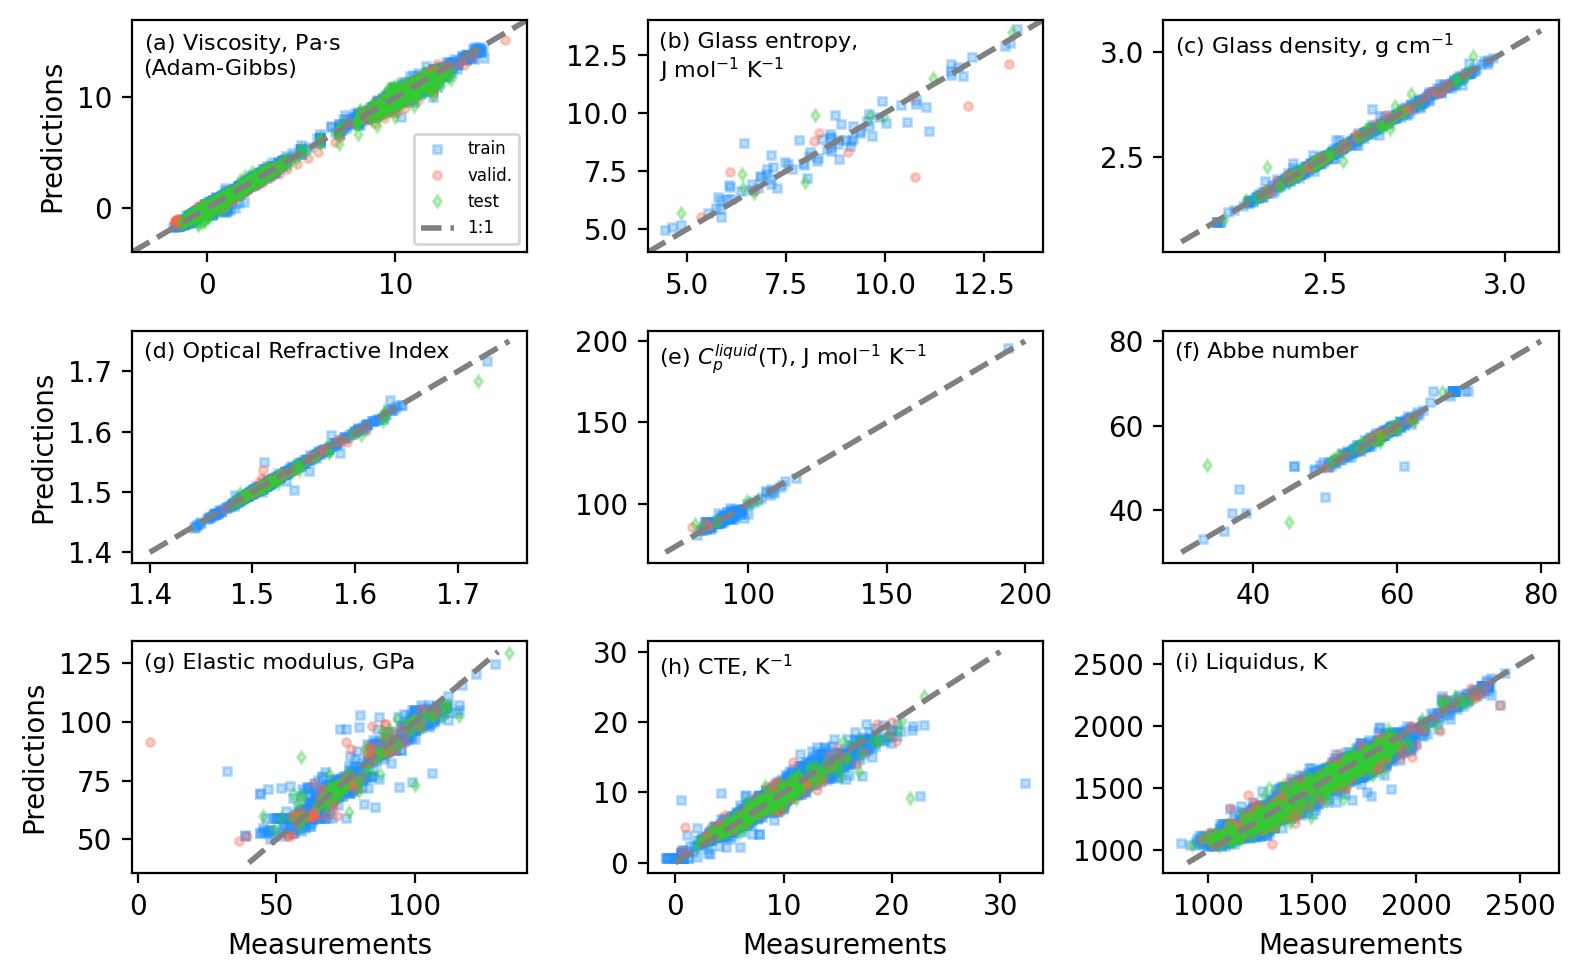

In [8]:
plt.figure(figsize=(8,5),dpi=200)

c1 = 'dodgerblue'
c2 = 'tomato'
c3 = 'limegreen'
alpha_=0.3
ms = 3

#
# Glass transition temperature
#
tx2 = plt.subplot(331)
tx2.plot(ds.y_visco_train.cpu().detach().numpy(),
         neuralmodel.predict("ag",ds.x_visco_train, ds.T_visco_train),
         "s",linestyle="none",color=c1,markersize=ms,label="train",alpha=alpha_)
tx2.plot(ds.y_visco_valid.cpu().detach().numpy(),
         neuralmodel.predict("ag",ds.x_visco_valid, ds.T_visco_valid),
         "o",color=c2,markersize=ms,label="valid.",alpha=alpha_)
tx2.plot(ds.y_visco_test.cpu().detach().numpy(),
         neuralmodel.predict("ag",ds.x_visco_test, ds.T_visco_test),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

plt.xlim(-4,17)
plt.ylim(-4,17)

#
# Configurational entropy
#
tx3 = plt.subplot(332)
tx3.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_train),
         "s",color=c1,markersize=ms,label="ent.",alpha=alpha_)
tx3.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_valid),
         "o",color=c2,markersize=ms,label="valid",alpha=alpha_)
tx3.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

plt.xlim(4,14)
plt.ylim(4,14)

#
# Density
#
tx4=plt.subplot(333)
tx4.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.predict("density_glass",ds.x_density_train),
         "s",color=c1,markersize=ms,label="ent.",alpha=alpha_)
tx4.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.predict("density_glass",ds.x_density_valid),
         "o",color=c2,markersize=ms,label="valid.",alpha=alpha_)
tx4.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density_glass",ds.x_density_test),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

#
# Refractive index
#
tx5 = plt.subplot(334)

l1 =tx5.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train),
         "s",color=c1,markersize=ms,label="entraînement",alpha=alpha_)
l2 = tx5.plot(ds.y_ri_valid.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid),
         "o",color=c2,markersize=ms,label="validation",alpha=alpha_)
l3 =tx5.plot(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

#
# LIQUID HEAT CAPACITY
#
tx6 = plt.subplot(335)

tx6.plot(ds.y_cpl_train.cpu().detach().numpy(),neuralmodel.predict("cpl",ds.x_cpl_train, T=ds.T_cpl_train),
         "s",color=c1,markersize=ms,label="entraînement",alpha=alpha_)
tx6.plot(ds.y_cpl_valid.cpu().detach().numpy(),neuralmodel.predict("cpl",ds.x_cpl_valid, T=ds.T_cpl_valid),
         "o",color=c2,markersize=ms,label="validation",alpha=alpha_)
tx6.plot(ds.y_cpl_test.cpu().detach().numpy(),neuralmodel.predict("cpl",ds.x_cpl_test, T=ds.T_cpl_test),
         "d",color=c3,markersize=ms,label="test",alpha=alpha_)

#
#ABBE NUMBER
#
tx7 = plt.subplot(336)
tx7.plot(ds.y_abbe_train.cpu().detach().numpy(),
         neuralmodel.predict("abbe", ds.x_abbe_train),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx7.plot(ds.y_abbe_valid.cpu().detach().numpy(),
         neuralmodel.predict("abbe", ds.x_abbe_valid),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx7.plot(ds.y_abbe_test.cpu().detach().numpy(),
         neuralmodel.predict("abbe", ds.x_abbe_test),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

#
# YOUNG MODULUS
#
tx8 = plt.subplot(337)
tx8.plot(ds.y_elastic_train.cpu().detach().numpy(),
         neuralmodel.predict("elastic_modulus", ds.x_elastic_train),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx8.plot(ds.y_elastic_valid.cpu().detach().numpy(),
         neuralmodel.predict("elastic_modulus", ds.x_elastic_valid),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx8.plot(ds.y_elastic_test.cpu().detach().numpy(),
         neuralmodel.predict("elastic_modulus", ds.x_elastic_test),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

#
# CTE
#
tx9 = plt.subplot(338)
tx9.plot(ds.y_cte_train.cpu().detach().numpy(),
         neuralmodel.predict("cte", ds.x_cte_train),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx9.plot(ds.y_cte_valid.cpu().detach().numpy(),
         neuralmodel.predict("cte", ds.x_cte_valid),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx9.plot(ds.y_cte_test.cpu().detach().numpy(),
         neuralmodel.predict("cte", ds.x_cte_test),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

#
# LIQUIDUS TEMPERATURE
#
tx10 = plt.subplot(339)
tx10.plot(ds.y_liquidus_train.cpu().detach().numpy(),
         neuralmodel.predict("liquidus", ds.x_liquidus_train),
         "s",color=c1,markersize=ms,label="train",alpha=alpha_)
tx10.plot(ds.y_liquidus_valid.cpu().detach().numpy(),
         neuralmodel.predict("liquidus", ds.x_liquidus_valid),
         "o",color=c2,markersize=ms,label="train",alpha=alpha_)
tx10.plot(ds.y_liquidus_test.cpu().detach().numpy(),
         neuralmodel.predict("liquidus", ds.x_liquidus_test),
         "d",color=c3,markersize=ms,label="train",alpha=alpha_)

# plot the 1:1 lines
tx2.plot([-4,17],[-4,17],"--",color="grey",linewidth=2,label="1:1")
tx3.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")
tx4.plot([2.1,3.1],[2.1,3.1],"--",color="grey",linewidth=2,label="1:1")
tx5.plot([1.4,1.75],[1.4,1.75],"--",color="grey",linewidth=2,label="1:1")
tx6.plot([70,200],[70,200],"--",color="grey",linewidth=2,label="1:1")
tx7.plot([30,80],[30,80],"--",color="grey",linewidth=2,label="1:1")
tx8.plot([40,130],[40,130],"--",color="grey",linewidth=2,label="1:1")
tx9.plot([0,30],[0,30],"--",color="grey",linewidth=2,label="1:1")
tx10.plot([900,2600],[900,2600],"--",color="grey",linewidth=2,label="1:1")

# labelling axis
tx2.set_ylabel("Predictions")
tx5.set_ylabel("Predictions")
tx8.set_ylabel("Predictions")
tx8.set_xlabel("Measurements")
tx9.set_xlabel("Measurements")
tx10.set_xlabel("Measurements")

# annotate the plots
subplot_titles=["(a) Viscosity, Pa$\cdot$s\n(Adam-Gibbs)",
                "(b) Glass entropy, \nJ mol$^{-1}$ K$^{-1}$",
                "(c) Glass density, g cm$^{-1}$",
                "(d) Optical Refractive Index",
                "(e) $C_p^{liquid}$(T), J mol$^{-1}$ K$^{-1}$",
                "(f) Abbe number",
                "(g) Elastic modulus, GPa",
                "(h) CTE, K$^{-1}$",
                "(i) Liquidus, K",
               ]
subplots = [tx2, tx3, tx4, tx5, tx6, tx7, tx8, tx9, tx10]
for i in range(9):
    subplots[i].annotate(subplot_titles[i],xy=(0.03,0.95),xycoords="axes fraction", fontsize=8, va="top")

# legend
tx2.legend(loc=4, fontsize=6)
    
plt.tight_layout()

plt.savefig("./figures/manuscript/Figure3.pdf")


# Viscosity predictions on specific compositions

In [9]:
# we load the full viscosity database
df2 = pd.read_excel("./data/Database.xlsx",sheet_name="VISCO")

# we get data for silica
silica = df2.loc[df2.Name_publi=="SiO2",:].reset_index()

# for Albite, Orthoclase, and 0.5-0.5 mixture, using names from publications
Ab = df2.loc[df2.Name_publi=="NAK75_12_0",:].reset_index()
Or = df2.loc[df2.Name_publi=="NAK75_12_12",:].reset_index()

# Anorthite
An = df2.loc[df2.Name=="sankmc_50_25_0_0_0_25",:].reset_index()

# An-Mg
AnMg = df2.loc[df2.Name=="sankmc_50_25_0_0_25_0"].reset_index()

#An50-Ab50 (Anorthite-Albite)
AnAb = df2.loc[df2.Name_publi=="An50"].reset_index()

# Alumina
al2o3_melt = df2.loc[df2.Name=="sankmc_0_100_0_0_0_0"].reset_index()

# geological andesite (iron-free)
andesite = df2.loc[df2.Name_publi=="Iron-free andesite"].reset_index()

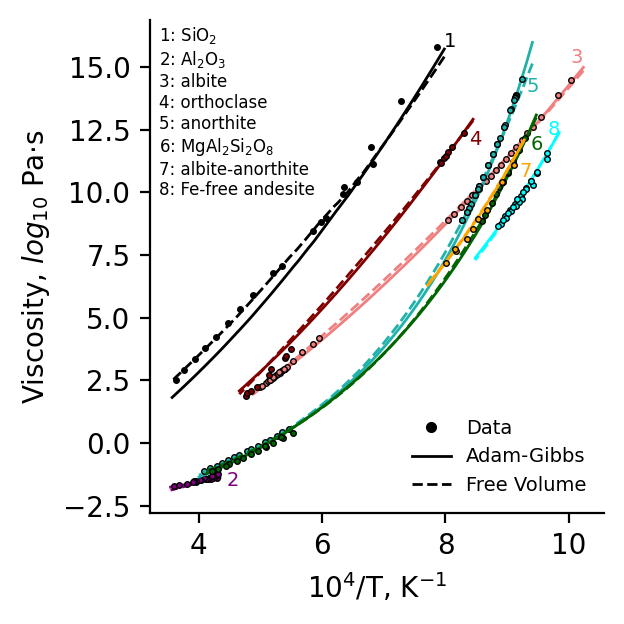

In [10]:
#
# We define utility functions to do the figure below
#
def plot_viscocurve(ax, dts, method = "ag",
                    color="k", marker="s", markersize=2,
                   annotation="bwa",rotation=0,relative_loc=[-10,-0.5]):
    """plot viscosity predictions given some arguments"""
    x_inter = np.arange(dts.loc[:,"T"].min()-20,dts.loc[:,"T"].max()+50,1.0)

    # extract data for future plot
    T_ = dts.loc[:,"T"]
    n_ = dts.viscosity
    
    # descriptor addition for ML predictions
    dts = utils.descriptors(dts.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100.0)
    
    # plot Adam-Gibbs and Free Volume models
    ax.plot(10000/x_inter,
             neuralmodel.predict("ag",
                                 torch.Tensor(dts.loc[0,:].values.astype('float')*np.ones((len(x_inter),dts.shape[1]))).to(device),
                                 torch.Tensor(x_inter.reshape(-1,1)).to(device)),
            color=color, linestyle="-", linewidth=1)
    
    ax.plot(10000/x_inter,
             neuralmodel.predict("cg",
                                 torch.Tensor(dts.loc[0,:].values.astype('float')*np.ones((len(x_inter),dts.shape[1]))).to(device),
                                 torch.Tensor(x_inter.reshape(-1,1)).to(device)),
            color=color, linestyle="--", linewidth=1)
        
    # plot data
    ax.plot(10000/T_, n_,"o", ms=markersize,mec="k",mew=mew,color=color)
    
    # automatic annotation
    x_ann = 10000/(np.min(T_)+relative_loc[0])
    y_ann = np.max(n_)+relative_loc[1]
    ax.annotate(annotation, 
                xy=(x_ann,y_ann), 
                xycoords="data", 
                fontsize=7, 
                rotation=rotation, 
                color=color)

    return ax

### 
### FIGURE GENERATION
###

fig1 = plt.figure(figsize=(3.22,3.22),dpi=200)

gs = GridSpec(1, 1, figure=fig1)
ax = fig1.add_subplot(gs[0, 0])

# colors
colors = {'SiO2':'black',
          'albite':'lightcoral',
          'orthoclase':'maroon',
          'AnMg':'darkgreen',
          'anorthite':"lightseagreen",
          'AnAb':"orange",
          'al2o3':"purple",
          'andesite':"cyan"
           }

mew=0.5

# for the dummy legend
ax.plot([],[],"ko",ms=3,lw=1,label="Data")
ax.plot([],[],"k-",lw=1,label="Adam-Gibbs")
ax.plot([],[],"k--",lw=1,label="Free Volume")
ax.legend(loc="lower right", frameon=False, fontsize=7)

# data

plot_viscocurve(ax, silica, color=colors['SiO2'], annotation="1", relative_loc=[-20,0.])
plot_viscocurve(ax, al2o3_melt, color=colors['al2o3'], annotation="2", relative_loc=[-75,-0.5])
plot_viscocurve(ax, Ab, color=colors['albite'], annotation="3", relative_loc=[0,+0.7])
plot_viscocurve(ax, Or, color=colors['orthoclase'], annotation="4")
plot_viscocurve(ax, An, color=colors['anorthite'], annotation="5")
plot_viscocurve(ax, AnMg, color=colors['AnMg'], annotation="6")
plot_viscocurve(ax, AnAb, color=colors['AnAb'], annotation="7")
plot_viscocurve(ax, andesite, color=colors['andesite'], annotation="8", relative_loc=[0,+0.7])

# axes labels
ax.set_ylabel("Viscosity, $log_{10}$ Pa$\cdot$s")
ax.set_xlabel("$10^4$/T, K$^{-1}$")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.annotate("1: SiO$_2$\n2: Al$_2$O$_3$\n3: albite\n4: orthoclase\n5: anorthite\n6: MgAl$_2$Si$_2$O$_8$\n7: albite-anorthite\n8: Fe-free andesite", 
            xy=(0.02,0.99),xycoords="axes fraction",
           fontsize=6, va="top")

plt.tight_layout()
plt.savefig("./figures/manuscript/Figure4.pdf")

# Raman spectra

The code below allows us to predict Raman spectra corresponding to those in the training and validation.

We generate a figure comparing predictions and observations.

Median Absolute Percentage Errors are also calculated.

Figure is generated randomly, so spectra may different from those in the manuscript.

Median Absolute Percentage Error on Train Raman dataset is 16.53%
Median Absolute Percentage Error on Valid Raman dataset is 15.98%
Median Absolute Percentage Error on Test Raman dataset is 25.39%


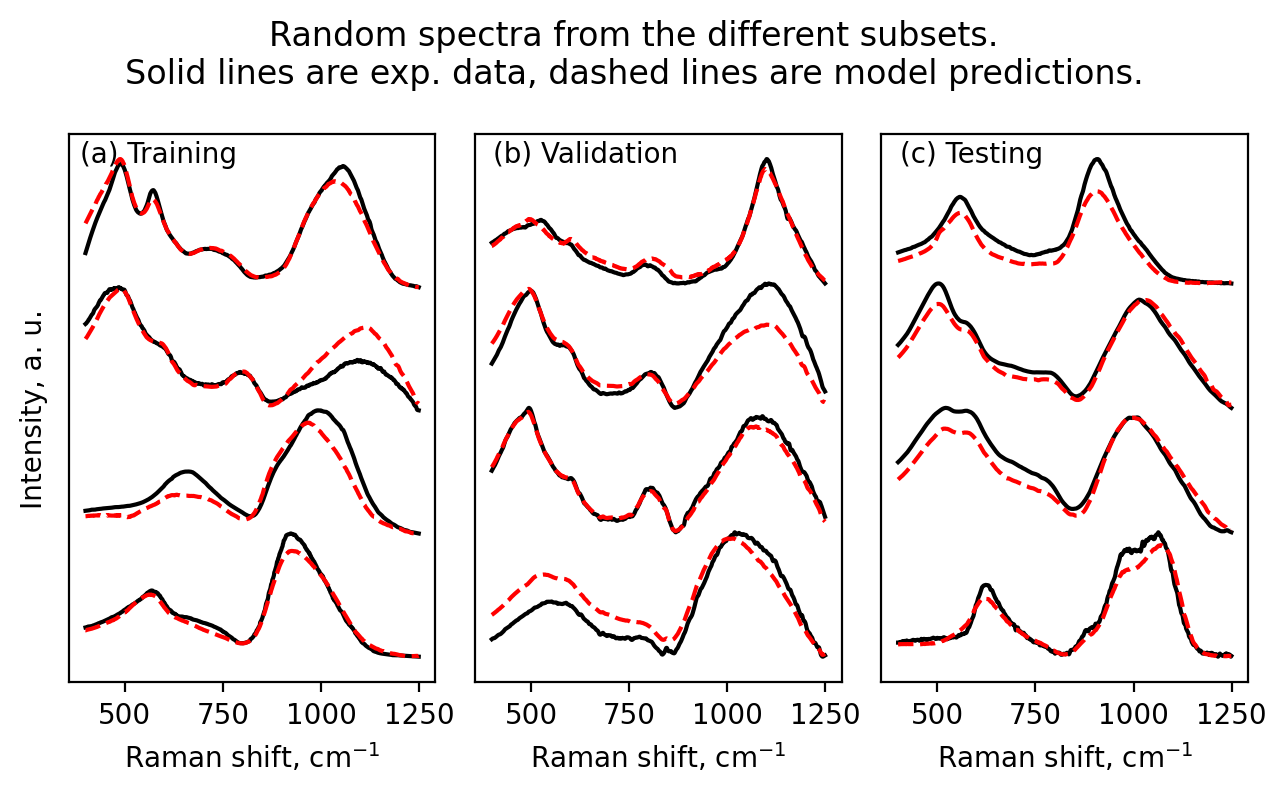

In [11]:
#
# Predictions for Raman spectra
#

# our real x axis, for resampling
x_raman_shift = np.arange(400.,1250.,1.0)

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid)
raman_test_predictions = neuralmodel.predict("raman_pred",ds.x_raman_test)

#
# Error on Raman data
#
Raman_error_train = np.zeros(ds.x_raman_train.shape[0])
for i in range(ds.x_raman_train.shape[0]):
    Raman_error_train[i] = np.median(np.abs((raman_train_predictions[i,:]-ds.y_raman_train[i,:].detach().numpy())
                                     /raman_train_predictions[i,:]))

Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error_valid[i] = np.median(np.abs((raman_valid_predictions[i,:]-ds.y_raman_valid[i,:].detach().numpy())
                                     /raman_valid_predictions[i,:]))

Raman_error_test = np.zeros(ds.x_raman_test.shape[0])
for i in range(ds.x_raman_test.shape[0]):
    Raman_error_test[i] = np.median(np.abs((raman_test_predictions[i,:]-ds.y_raman_test[i,:].detach().numpy())
                                     /raman_test_predictions[i,:]))

print("Median Absolute Percentage Error on Train Raman dataset is {0:.2f}%".format(np.median(Raman_error_train)*100))
print("Median Absolute Percentage Error on Valid Raman dataset is {0:.2f}%".format(np.median(Raman_error_valid)*100))
print("Median Absolute Percentage Error on Test Raman dataset is {0:.2f}%".format(np.median(Raman_error_test)*100))

#
# Figure for the Raman spectra
#
plt.figure(figsize=(6.44,4), dpi=200)
plt.suptitle("Random spectra from the different subsets.\nSolid lines are exp. data, dashed lines are model predictions.")
plt.subplot(1,3,1)
plt.annotate("(a) Training",xy=(0.03,0.99),xycoords="axes fraction", va="top")
shift=0
sp_id = np.random.randint(0,high=ds.x_raman_train.shape[0],size=4)
for i in sp_id:
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,"r--")
    shift += 1.
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")
plt.yticks([])

plt.subplot(1,3,2)
plt.annotate("(b) Validation",xy=(0.05,0.99),xycoords="axes fraction", va="top")
shift = 0.
sp_id = np.random.randint(0,high=ds.x_raman_valid.shape[0],size=4)
for i in sp_id:
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,"r--")
    shift += 1.
    
plt.yticks([])
plt.xlabel("Raman shift, cm$^{-1}$")

plt.subplot(1,3,3)
plt.annotate("(c) Testing",xy=(0.05,0.99),xycoords="axes fraction", va="top")
shift = 0.
sp_id = np.random.randint(0,high=ds.x_raman_test.shape[0],size=4)
for i in sp_id:
    plt.plot(x_raman_shift,ds.y_raman_test[i,:].detach().numpy()+shift,"k-")
    plt.plot(x_raman_shift,raman_test_predictions[i,:]+shift,"r--")
    shift += 1.

plt.yticks([])
plt.xlabel("Raman shift, cm$^{-1}$")

plt.tight_layout()



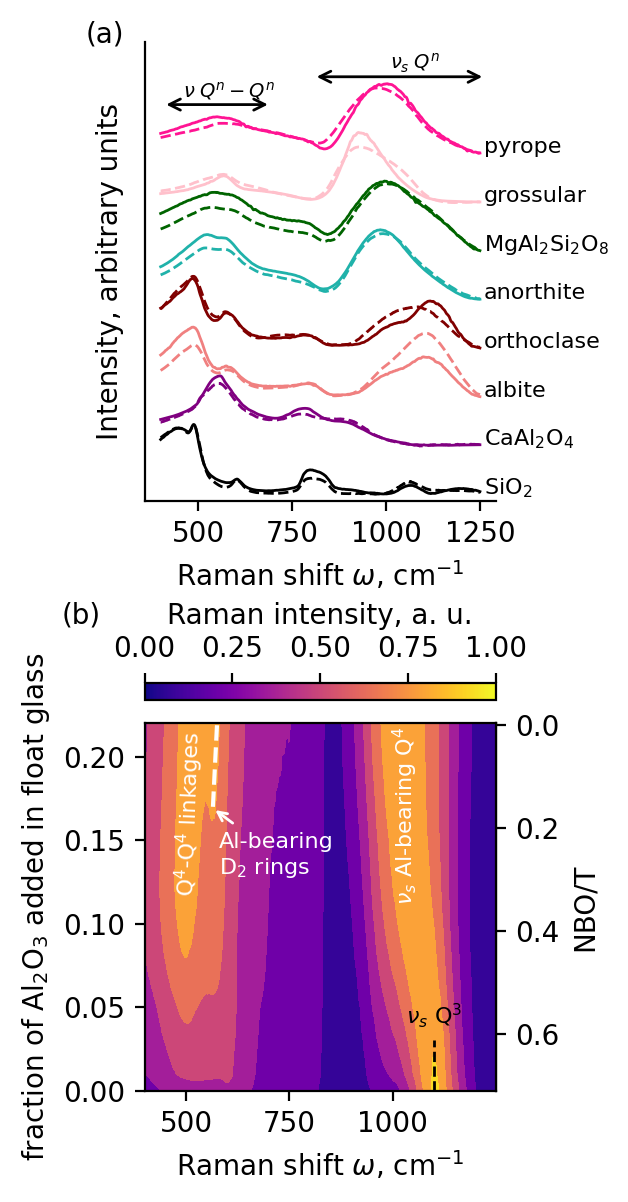

In [12]:
#
# we associate a tuple of names and colors with specific spectra files that we want to plot, 
#
spectres = {'SiO$_2$':('BC029_SiO2.txt','black'),
            'CaAl$_2$O$_4$': ('AC5717-CA.txt','purple'),
            'albite':('ae0836.txt','lightcoral'),
            'orthoclase':('ae0841.txt','maroon'),
            'anorthite':('AC1376-CA5025.txt','lightseagreen'),
            'MgAl$_2$Si$_2$O$_8$':('AD3430-MA5025.txt','darkgreen'),
            'grossular':('AC1038-CA4214.txt','pink'),
            'pyrope':('AD3439-MA4214.txt','deeppink'),
            }

# we look at the database in Excel to get corresponding compositions

# we first load the Raman database
df3 = pd.read_excel("./data/Database.xlsx",sheet_name="RAMAN")

# then we get the compositions corresponding to file names
data_compos = pd.DataFrame()
for i in spectres.keys():
    data_compos = pd.concat((data_compos, df3.loc[df3.nom==spectres[i][0]]))
data_compos = data_compos.reset_index()

#
# now we need to retrieve the compositions in the train/valid/test Raman data subsets stored in HDF5
#

# first we need to add descriptors
x_r_compos = torch.FloatTensor(utils.descriptors(data_compos.loc[:,"sio2":"cao"]/100).values)

# then we search if those compositions are in the train, valid or test X subsets
ind_compos = np.zeros((len(x_r_compos), 2))
for k in range(len(x_r_compos)) :
    
    a = x_r_compos[k] == ds.x_raman_train 
    b = x_r_compos[k] == ds.x_raman_valid
    c = x_r_compos[k] == ds.x_raman_test
    
    for i in range(len(a)):
        if a[i].all() == True :
            ind_compos[k,0] = i
            ind_compos[k,1] = 0 #0 for train subset
    
    for i in range(len(b)):
        if b[i].all() == True :
            ind_compos[k,0] = i
            ind_compos[k,1] = 1 #1 for valid susbset
            
    for i in range(len(c)):
        if c[i].all() == True :
            ind_compos[k,0] = i
            ind_compos[k,1] = 2 #2 for test susbset

# we get the corresponding spectra from the good subset        
y_r_compos = np.zeros((len(ind_compos), len(ds.y_raman_train[0])))

for i in range(len(ind_compos)):
    if ind_compos[i,1] == 0 :
        y_r_compos[i,:] = ds.y_raman_train[int(ind_compos[i,0])]
    elif ind_compos[i,1] == 1 :
        y_r_compos[i,:] = ds.y_raman_valid[int(ind_compos[i,0])]
    elif ind_compos[i,1] == 2 :
        y_r_compos[i,:] = ds.y_raman_test[int(ind_compos[i,0])]
        
# and we get predictions
y_r_pred = np.zeros((len(ind_compos), len(ds.y_raman_train[0])))
for i in range(len(ind_compos)):   
    y_r_pred[i,:] = neuralmodel.predict("raman_pred", x_r_compos[i,:].reshape(1,-1)).ravel()
    
#
# start figure
#
plt.figure(figsize=(3.22,6), dpi=200)

#
# FIRST SUBPLOT OF OBSERVED DATA VS PREDICTIONS
#

ax1 = plt.subplot(211)

shift = 0 # this variable will be used for shifting each pair of spectra
for count,i in enumerate(spectres):
    
    # plot data and prediction
    plt.plot(ds.x_raman_shift, y_r_compos[count,:] + shift,"-",color=spectres[i][1],linewidth=1.0)
    plt.plot(ds.x_raman_shift, y_r_pred[count,:] + shift,"--",color=spectres[i][1],linewidth=1.0)
    
    # annotate
    plt.annotate(i, xy=(1260, shift), fontsize=8)
    
    shift += 0.7 # incrementing the shift variable
    
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.yticks([])
ax1.set_xlabel('Raman shift $\omega$, cm$^{-1}$')
ax1.set_ylabel('Intensity, arbitrary units')
ax1.set_ylim(-0.1, 6.5)

# add annotations for the vibrational modes
ax1.annotate('', xy=(400,5.6), xytext=(700,5.6), xycoords="data",arrowprops=dict(arrowstyle='<->'))
ax1.annotate(r"$\nu \; Q^{n}-Q^{n}$",xy = (460,5.7),xycoords="data",fontsize=7)

ax1.annotate('', xy=(800,6.0), xytext=(1270,6.0), xycoords="data",arrowprops=dict(arrowstyle='<->'))
ax1.annotate(r"$\nu_s \; Q^{n}$",xy = (1010,6.1),xycoords="data",fontsize=7)

#
# SECOND SUBPLOT OF SYSTEMATIC PREDICTIONS
#

# adding Al in composition
X_float = np.array([72.1,0.0,13.1,0.0,5.8,9.0]).reshape(1,-1) # typical float glass composition, Al free
X_al_float = np.array([0.,100.,0.,0.,0.,0.]).reshape(1,-1)
X_mix_float = np.arange(0,0.23,0.01).reshape(-1,1)
X_float_raman = (1-X_mix_float)*X_float + X_mix_float*X_al_float
Al_float = X_float_raman[:,1]/100

T = X_float_raman[:,0] + 2*X_float_raman[:,1]
O = (X_float_raman[:,0]*2
     + 3*X_float_raman[:,1] 
     + X_float_raman[:,2] 
     + X_float_raman[:,3] 
     + X_float_raman[:,4] 
     + X_float_raman[:,5])
nbot_float = (2*O - 4*T)/T

X_float_raman = utils.descriptors(pd.DataFrame(X_float_raman, 
                                            columns=["sio2","al2o3","na2o","k2o","mgo","cao"])/100.0)

# and we get predictions
raman_float_pred = neuralmodel.predict("raman_pred", X_float_raman.values)

# get nulmber of sp
nb_sp = raman_float_pred.shape[0]

# start figure
ax2 = plt.subplot(212)

c_m = matplotlib.cm.plasma # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m) # create a ScalarMappable and initialize a data structure

ax2.contourf((np.ones((len(ds.x_raman_shift),nb_sp))*ds.x_raman_shift.reshape(-1,1)),
                (np.ones((len(ds.x_raman_shift),nb_sp))*Al_float.reshape(1,-1)),
                raman_float_pred.T, cmap=c_m)

# add the NBO/T on the right side Y axis
def al_to_nbot(al):
    return -3.24560553*al + 0.71089556

def nbot_to_al(nbot):
    return -0.30436043*nbot + 0.21807173

secax_y = ax2.secondary_yaxis(
    'right', functions=(al_to_nbot, nbot_to_al))
secax_y.set_ylabel(r'NBO/T')

# add labels
ax2.set_xlabel("Raman shift $\omega$, cm$^{-1}$")
ax2.set_ylabel("fraction of Al$_2$O$_3$ added in float glass")

plt.tight_layout() # we call now the tight layout because the colorbar moves it...

# add colorbar
cbar_ = plt.colorbar(mappable=s_m, ax=[ax2,], location='top')
cbar_.set_label(r"Raman intensity, a. u.")

plt.annotate("Q$^4$-Q$^4$ linkages", xy=(462,0.01), xytext=(465, 0.12), 
             color="white", fontsize=8, rotation = 88, fontweight="normal")

plt.annotate(r"$\nu_s$ Al-bearing Q$^4$", xy=(1030,0.115), color="w", 
             fontsize=8, rotation = 90, fontweight="normal", ha="center")

plt.annotate(r"$\nu_s$ Q$^3$", xy=(1100,0.04), 
             color="black", fontsize=8, rotation = 0, 
             fontweight="normal", ha="center",
            )
plt.plot([1100, 1100], [0.0,0.03], "--k", linewidth=1)

plt.annotate("Al-bearing\nD$_2$ rings", xy=(560,0.17), xytext=(580, 0.13), 
             color="white", fontsize=8, rotation = 0, fontweight="normal",
            arrowprops=dict(arrowstyle="->",color="white"))
plt.plot([565, 575], [0.17,0.22], "--w")

ax1.text(200, 6.5, "(a)")
ax2.text(200, 0.28, "(b)")

plt.savefig("./figures/manuscript/Figure5.pdf")

# Predicting details: the mixed alkali effect

Comparison of model predictions of Tg during mixture of metal cations with data from difference studies.

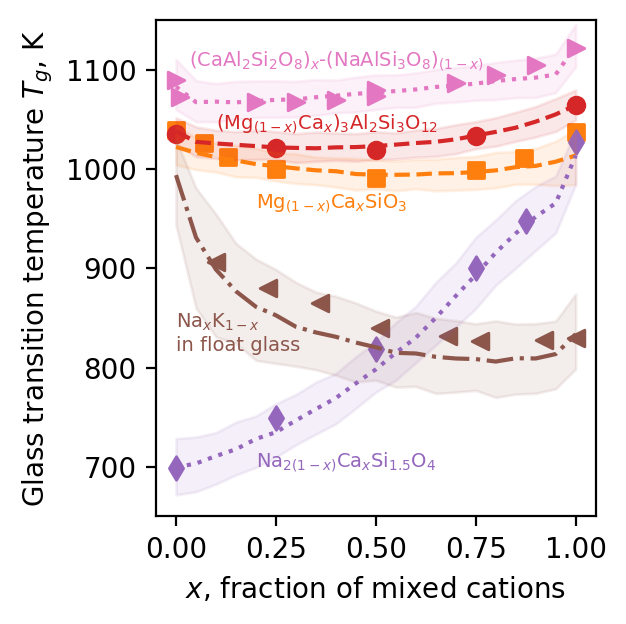

In [13]:
X_interp = np.arange(0,1.05,0.05)

# Albite-Anorthite, Hummelt Arndt 1985
AnAb_X = np.array([0., 0.01, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7, 0.8, 0.9, 1.0])
AnAb_Tg = np.array([1089.1, 1072.1, 1067.3, 1067.3, 1069.3, 1073.4, 1079.4, 1086.2, 1094.3, 1104.3, 1121.3])

AnAb_compo = np.zeros([len(X_interp),6])

for i in range(len(X_interp)):
    Ab_compo = np.array([0.75, 0.125, 0.125, 0., 0., 0.]).reshape(1,-1)
    An_compo = np.array([0.5, 0.25, 0., 0., 0., 0.25]).reshape(1,-1)
    AnAb_compo[i,:] = X_interp[i]*An_compo + (1-X_interp[i])*Ab_compo
    
AnAb_compo = utils.descriptors(pd.DataFrame(AnAb_compo, 
                                            columns=["sio2","al2o3","na2o","k2o","mgo","cao"])/100.0)

# Na-K in float glass, Kjeldsen 2014 JNCS 406
X_float = np.array([0.1, 0.23, 0.36, 0.51, 0.68, 0.76, 0.92, 1.])
Tg_float = np.array([906.5, 880., 865., 840., 832., 827., 828., 830.])

compo_float = pd.DataFrame(X_interp*12.9, columns=["na2o",])
compo_float["sio2"] = 71.7
compo_float["al2o3"] = 0.6
compo_float["k2o"] = 12.9-compo_float["na2o"]
compo_float["mgo"] = 5.7
compo_float["cao"] = 8.9
compo_float = utils.descriptors(compo_float.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100.0)

# Ca-Mg in (Ca,Mg)SiO3, Neuville 1991
Wo_X = np.array([0.0, 3.5, 6.5, 12.5, 25., 37.5, 43.5, 50.0])/50
Wo_Tg = np.array([1039., 1026., 1012., 1000., 991., 999., 1011., 1037])

compo_ = pd.DataFrame(X_interp*50., columns=["cao",])
compo_["sio2"] = 50.
compo_["al2o3"] = 0.
compo_["na2o"] = 0.
compo_["k2o"] = 0.
compo_["mgo"] = 50.-compo_["cao"]
compo_ = utils.descriptors(compo_.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100.0)

# Gr mixing Neuville 1991
Gr_X = np.array([0., 0.25, 0.5, 0.75, 1.0])
Gr_Tg = np.array([1035., 1021., 1019., 1033., 1064])

compo_gr = pd.DataFrame(X_interp*42.90, columns=["cao",])
compo_gr["sio2"] = 42.90
compo_gr["al2o3"] = 14.30
compo_gr["na2o"] = 0.
compo_gr["k2o"] = 0.
compo_gr["mgo"] = 42.90-compo_gr["cao"]
compo_gr = utils.descriptors(compo_gr.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100.0)

# Ca-Na in silicates, Neuville 2006
CN_X = np.array([0, 0.25, 0.50, 0.75, 35/40., 1.0])
CN_Tg = np.array([698.5, 749.5, 818.8, 899.9, 947.3, 1027.1])

compo_cn = pd.DataFrame(X_interp*40.0, columns=["cao",])
compo_cn["sio2"] = 60.0
compo_cn["al2o3"] = 0.0
compo_cn["na2o"] = 40.-compo_cn["cao"]
compo_cn["k2o"] = 0.
compo_cn["mgo"] = 0.0
compo_cn = utils.descriptors(compo_cn.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100.0)

# predictions
Wo_Tg_preds = neuralmodel.predict("tg", compo_.values, sampling=True, n_sample=50)
Gr_Tg_preds = neuralmodel.predict("tg", compo_gr.values, sampling=True, n_sample=50)
CN_Tg_preds = neuralmodel.predict("tg", compo_cn.values, sampling=True, n_sample=50)
F_Tg_preds = neuralmodel.predict("tg", compo_float.values, sampling=True, n_sample=50)
AnAb_Tg_preds = neuralmodel.predict("tg", AnAb_compo.values, sampling=True, n_sample=50)

#
# FIGURE
#
plt.figure(figsize=(3.22, 3.22),dpi=200)

ax1 = plt.subplot(111)

# data
ax1.scatter(Wo_X, Wo_Tg, marker="s", color="C1")
ax1.scatter(Gr_X, Gr_Tg, marker="o", color="C3")
ax1.scatter(CN_X, CN_Tg, marker="d", color="C4")
ax1.scatter(X_float, Tg_float, marker="<", color="C5")
ax1.scatter(AnAb_X, AnAb_Tg, marker=">", color="C6")

# model
ax1.plot(X_interp, np.median(Wo_Tg_preds, axis=1), color="C1", linestyle="--")
ax1.plot(X_interp, np.median(Gr_Tg_preds, axis=1), color="C3", linestyle="--")
ax1.plot(X_interp, np.median(CN_Tg_preds, axis=1), color="C4", linestyle=":")
ax1.plot(X_interp, np.median(F_Tg_preds, axis=1), color="C5", linestyle="-.")                           
ax1.plot(X_interp, np.median(AnAb_Tg_preds, axis=1), color="C6", linestyle=":")                           

ax1.fill_between(X_interp, 
                 np.quantile(Wo_Tg_preds,0.025, axis=1), 
                 np.quantile(Wo_Tg_preds,0.975, axis=1), 
                 color="C1", alpha=0.1)

ax1.fill_between(X_interp, 
                 np.quantile(Gr_Tg_preds,0.025, axis=1), 
                 np.quantile(Gr_Tg_preds,0.975, axis=1), 
                 color="C3", alpha=0.1)

ax1.fill_between(X_interp, 
                 np.quantile(CN_Tg_preds,0.025, axis=1), 
                 np.quantile(CN_Tg_preds,0.975, axis=1), 
                 color="C4", alpha=0.1)

ax1.fill_between(X_interp, 
                 np.quantile(F_Tg_preds,0.025, axis=1), 
                 np.quantile(F_Tg_preds,0.975, axis=1), 
                 color="C5", alpha=0.1)

ax1.fill_between(X_interp, 
                 np.quantile(AnAb_Tg_preds,0.025, axis=1), 
                 np.quantile(AnAb_Tg_preds,0.975, axis=1), 
                 color="C6", alpha=0.1)

# set limits
ax1.set_ylim(650,1150)

# set labels of axis
ax1.set_xlabel("$x$, fraction of mixed cations")
ax1.set_ylabel("Glass transition temperature $T_g$, K")

ax1.annotate('Mg$_{(1-x)}$Ca$_x$SiO$_3$', xy=(0.2, 960), xycoords="data", fontsize=7, color="C1")
ax1.annotate('(Mg$_{(1-x)}$Ca$_x$)$_3$Al$_2$Si$_3$O$_{12}$', xy=(0.1, 1040), xycoords="data", fontsize=7, color="C3")
ax1.annotate('Na$_{2(1-x)}$Ca$_x$Si$_{1.5}$O$_4$', xy=(0.2, 700), xycoords="data", fontsize=7, color="C4")
ax1.annotate('Na$_x$K$_{1-x}$\nin float glass', xy=(0.0, 856), xycoords="data", fontsize=7, va="top", color="C5")
ax1.annotate(r'(CaAl$_2$Si$_2$O$_8$)$_x$-(NaAlSi$_3$O$_8$)$_{(1-x)}$', xy=(0.4, 1120), xycoords="data", fontsize=7, ha="center", va="top", color="C6")

plt.tight_layout()

plt.savefig("./figures/manuscript/Figure6.pdf")


# Fragility versus $C_p^{conf}/S^{conf}(T_g)$

A linear relationship should be visible according to the works of Webb (2008) or Russell and Giordano (2017)

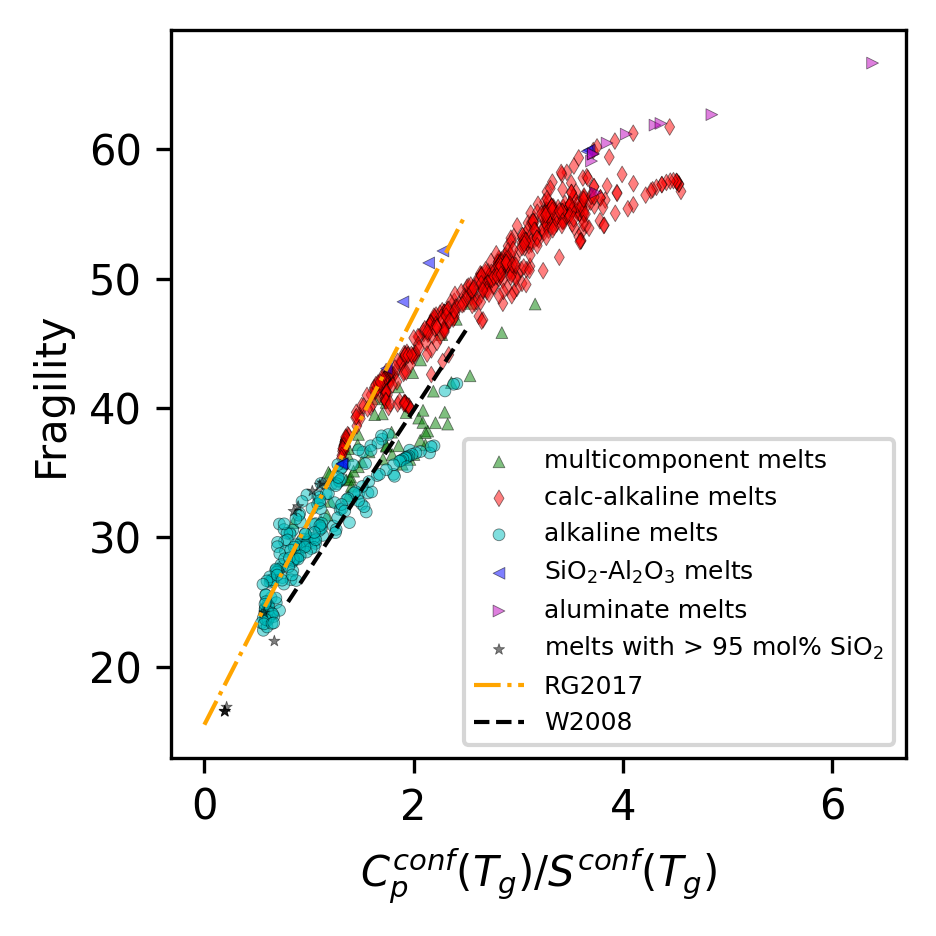

In [14]:
def color_data(chemical_set):
    colors = np.empty(len(chemical_set), dtype="str") # an array to contain my colors
    
    #colors[:] = "green"
    
    # all mixed
    colors[(chemical_set[:,2:4] > 0).any(axis=1) &
           (chemical_set[:,4:6] > 0).any(axis=1)
          ] = "g"
    
    # calc-alkali
    colors[(chemical_set[:,2:4] == 0).all(axis=1) &
           (chemical_set[:,4:6] >= 0).any(axis=1)
          ] = "r" 
    
    # alkali
    colors[(chemical_set[:,2:4] >= 0).any(axis=1) &
           (chemical_set[:,4:6] == 0).all(axis=1)
          ] = "c"
    
    # sio2-al2o3
    colors[(chemical_set[:,0:2] > 0).any(axis=1) &
           (chemical_set[:,2:6] == 0).all(axis=1)
          ] = "b" 
    
    # aluminate
    colors[chemical_set[:,0] == 0] = "m" 
    
    # silica rich = black
    colors[chemical_set[:,0] > 0.95] = "k"
    
    return colors


dict_marker = {"g":"s",
               "r":"o",
               "c":"d",
               "b":"<",
               "m":">",
               "k":"*"
              }

plt.figure(figsize=(3.22,3.22),dpi=300)
ax = plt.subplot()


# plotting i-Melt predictions
x_visco_all = torch.cat((ds.x_visco_train, ds.x_visco_valid, ds.x_visco_test))
# get only unique values
ds_in = torch.unique(x_visco_all, dim=0)

# calculate thermodynamic properties
Cpconf = (neuralmodel.predict("ap_calc",ds_in) + 
      neuralmodel.predict("bCpl",ds_in)*
      neuralmodel.predict("tg",ds_in))
Cp_S = Cpconf/neuralmodel.predict("sctg",ds_in)
fragil = neuralmodel.predict("fragility",ds_in)
    
colored_array = color_data(ds_in)
    
# plot things
symbols_ = ["^","d","o","<",">","*"]
labels_ = ["multicomponent melts",
           "calc-alkaline melts",
           "alkaline melts",
           "SiO$_2$-Al$_2$O$_3$ melts",
           "aluminate melts",
           "melts with > 95 mol% SiO$_2$"]
for count,i in enumerate(["g","r","c","b","m","k"]):
    ax.scatter(Cp_S[colored_array==i], fragil[colored_array==i],
            marker=symbols_[count],
            edgecolors="k",linewidths=0.2,
            c=colored_array[colored_array==i],
            s=8, alpha=0.5,
              label=labels_[count])

# plotting published trends
ax.plot([0., 2.5], [15.51, 55], "-.", color="orange", linewidth=1, label="RG2017", alpha=1., zorder=1)
ax.plot([0.8, 2.5], [25., 46], "--", color="k", linewidth=1, label="W2008", alpha=1., zorder=1)
plt.legend(fontsize = 6, loc=4)

plt.xlabel(r"$C_p^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("Fragility")
plt.tight_layout()
plt.savefig("./figures/manuscript/Figure7.pdf")



# Confidence interval analysis

First we calculate how much data fall within the 95% confidence intervals calculated using MC dropout. Ideally, 95% of the data should fall in the provided confidence intervals. We use conformal prediction to scale the MC dropout c.i.s

Second, we show how we can detect extrapolation with MC dropout error bars.

In [15]:
def evaluate_accuracy(y, ci_lower=0, ci_upper=0, samples = np.array([]), ci_level=0.95, verbose=False):
    """Evaluate the accuracy of the error bars.

    Provide either the ci_lower and ci_upper values, or an array of samples.

    If you provide an array, the quantiles will be calculated from the array.
    This will be done with taking into account of the ci_level parameter.

    Parameters
    ----------
    y : array
        the observed Y values.
    ci_lower : array
        the lower confidence interval.
    ci_upper : array
        the upper confidence interval.
    samples : array
        the samples from the MC Dropout.
    ci_level : float
        the level of confidence interval. Default is 0.95.
    verbose : bool
        whether to print the accuracy of the error bars. Default is False.

    Returns
    -------
    ic_acc : float
        the accuracy of the error bars.
    percent_above : float
        the percentage of samples above the lower error bar.
    percent_below : float
        the percentage of samples below the upper error bar.
    """
    if samples.shape[0] != 0:
        ci_lower = np.quantile(samples, (1-ci_level)/2, axis=samples.ndim-1)
        ci_upper = np.quantile(samples, ci_level+(1-ci_level)/2, axis=samples.ndim-1)
    else:
        if (ci_upper.all() == 0) or (ci_lower.all()==0):
            raise ValueError("Provide the ci values")
    
    ic_acc = (ci_lower <= y.ravel()) * (ci_upper >= y.ravel())
    ic_acc = ic_acc.mean()
    percent_above = (ci_lower <= y.ravel()).mean()
    percent_below = (ci_upper >= y.ravel()).mean()
    
    if verbose == True:
        print("accuracy of MC Dropout error bars: {.3f}".format(ic_acc))
        print("Percentage of samples above lower c.i.:".format((ci_lower <= y.ravel()).float().mean()))
        print("Percentage of samples below upper c.i.:".format((ci_upper >= y.ravel()).float().mean()))
    return ic_acc, percent_above, percent_below


methods_ = ["Density","Viscosity","Optical refractive index",
            "Liquidus", "Heat capacity", "Abbe","Elastic","CTE","raman"]
df_errors = pd.DataFrame(methods_, columns=["method"])
df_errors["MC dropout"]=0.0
df_errors["with C.P."]=0.0
n_sample=200


x_cal= (ds.x_density_valid, ds.x_visco_valid, ds.x_ri_valid, ds.x_liquidus_valid,
        ds.x_cpl_valid, ds.x_abbe_valid, ds.x_elastic_valid, ds.x_cte_valid, ds.x_raman_valid)
y_cal= (ds.y_density_valid, ds.y_visco_valid, ds.y_ri_valid, ds.y_liquidus_valid,
        ds.y_cpl_valid, ds.y_abbe_valid, ds.y_elastic_valid, ds.y_cte_valid, ds.y_raman_valid)

x_test= (ds.x_density_test, ds.x_visco_test, ds.x_ri_test, ds.x_liquidus_test,
        ds.x_cpl_test, ds.x_abbe_test, ds.x_elastic_test, ds.x_cte_test, ds.x_raman_test)
y_test= (ds.y_density_test, ds.y_visco_test, ds.y_ri_test, ds.y_liquidus_test,
        ds.y_cpl_test, ds.y_abbe_test, ds.y_elastic_test, ds.y_cte_test, ds.y_raman_test)

methods = ("density_glass","ag","sellmeier","liquidus","cpl","abbe","elastic_modulus","cte","raman_pred")

for i,names in enumerate(methods):
    if names == "ag":
        T_cal=ds.T_visco_valid
        T_test=ds.T_visco_test
    elif names == "cpl":
        T_cal=ds.T_cpl_valid
        T_test=ds.T_cpl_test
    else:
        T_cal = []
        T_test = []
    if names == "sellmeier":
        lbd_cal = ds.lbd_ri_valid
        lbd_test = ds.lbd_ri_test
    else:
        lbd_cal=[]
        lbd_test=[]
    
    y_preds_cal = neuralmodel.predict(names,x_cal[i],T=T_cal,lbd=lbd_cal,sampling=True, n_sample=n_sample)
    
    y_preds_test = neuralmodel.predict(names,x_test[i],T=T_test,lbd=lbd_test,sampling=True, n_sample=n_sample)
    

    if names=="raman_pred":
        # calculate c.i.
        ci_lower = np.quantile(y_preds_test, 0.025, axis=2)
        ci_upper = np.quantile(y_preds_test, 0.975, axis=2)
        
        # calculate how much data fall in those c.i.
        # this only works for the 3d arrays of Raman, for 2d arrays you need a ravel
        ic_acc = (ci_lower <= y_test[i].detach().numpy()) * (ci_upper >= y_test[i].detach().numpy())
        ic_acc_mc = ic_acc.mean()
        
        # record the calibration shape
        y_sh = y_preds_cal.shape

        # record the shape of the prediction target
        raman_sh = y_preds_test.shape

        # create an array to store the new c.i.
        raman_cred_intervals = np.zeros((raman_sh[0], raman_sh[1], 2))

        # we correct the c.i. at each Raman shift
        for j in range(raman_sh[1]):
            # correction of confidence intervals with Conformal Regression from aws fortuna
            cred_intervals = QuantileConformalRegressor().conformal_interval(
            val_lower_bounds=np.quantile(y_preds_cal[:,j,:].reshape(y_sh[0],y_sh[2]),0.025, axis=1), # calibration predicted lower bound
            val_upper_bounds=np.quantile(y_preds_cal[:,j,:].reshape(y_sh[0],y_sh[2]),0.975, axis=1), # calibration predicted upper bound
            val_targets=y_cal[i][:,j].reshape(-1,1).detach().numpy(), # calibration target
            test_lower_bounds=np.quantile(y_preds_test[:,j,:].reshape(raman_sh[0],raman_sh[2]),0.025, axis=1), # unseen prediction
            test_upper_bounds=np.quantile(y_preds_test[:,j,:].reshape(raman_sh[0],raman_sh[2]),0.975, axis=1), # unseen prediction
            error=0.05 # desired precision
            )
    
            raman_cred_intervals[:,j,:] = cred_intervals

        ci_lower = raman_cred_intervals[:,:,0]
        ci_upper = raman_cred_intervals[:,:,1]
        
        # calculate how much data fall in those c.i.
        # this only works for the 3d arrays of Raman, for 2d arrays you need a ravel
        ic_acc = (ci_lower <= y_test[i].detach().numpy()) * (ci_upper >= y_test[i].detach().numpy())
        df_errors.loc[i,"with C.P."] = ic_acc.mean()
    
        
    else:
        ic_acc_mc, _, _ = utils.evaluate_accuracy(y_test[i].detach().numpy(),
                                            samples = y_preds_test
                                            )
        
        # correction of confidence intervals with Conformal Regression from aws fortuna
        test_cred_intervals = QuantileConformalRegressor().conformal_interval(
        val_lower_bounds=np.quantile(y_preds_cal,0.025, axis=1),
        val_upper_bounds=np.quantile(y_preds_cal,0.975, axis=1),
        test_lower_bounds=np.quantile(y_preds_test,0.025, axis=1),
        test_upper_bounds=np.quantile(y_preds_test,0.975, axis=1),
        val_targets=y_cal[i].detach().numpy(),
        error=0.05
        )
        
        df_errors.loc[i,"with C.P."], _, _ = utils.evaluate_accuracy(y_test[i].detach().numpy(),
                                                                ci_lower=test_cred_intervals[:,0],
                                                                ci_upper=test_cred_intervals[:,1])

    # record errors
    df_errors.loc[i,"MC dropout"] = ic_acc_mc
    

In [16]:
df_errors

,method,MC dropout,with C.P.
0,Density,0.869565,0.869565
1,Viscosity,0.896166,0.944089
2,Optical refractive index,0.904762,0.968254
3,Liquidus,0.846639,0.964286
4,Heat capacity,0.571429,0.857143
5,Abbe,0.814815,0.777778
6,Elastic,0.757282,0.941748
7,CTE,0.837945,0.972332
8,raman,0.697919,0.975113


# Observation of predictions and their uncertainties in a ternary system

This is observed in the CaO-Al$_2$O$_3$-SiO$_2$ diagram, here using ternary plots of density.

This can be adapted to plot other properties, or other systems of course.

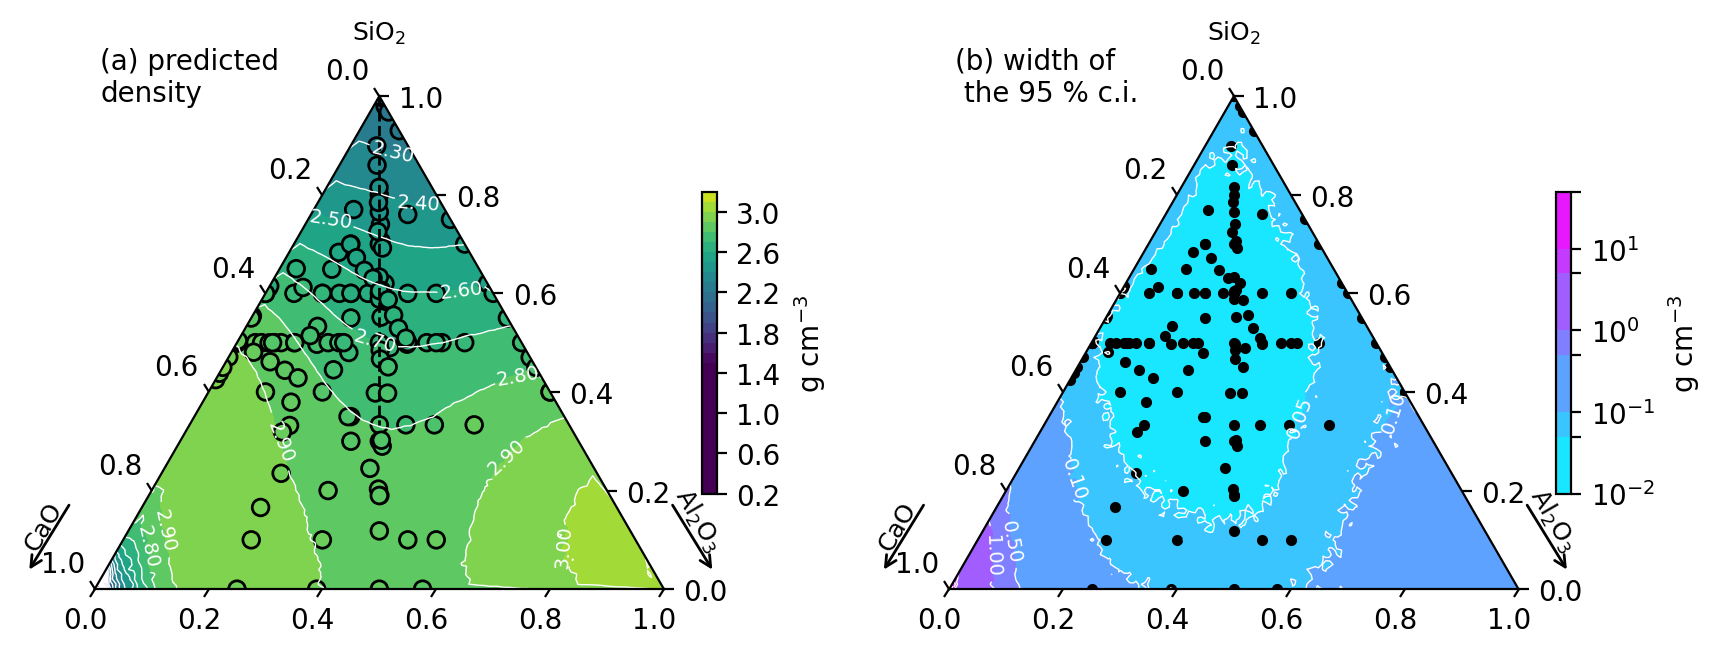

In [17]:
# helper functions
def plot_ternary(ax, x_1, x_2, x_3, z, 
                 colormap, norm, log=False,
                 levels_1=30, levels_2=6, 
                 label_cbar='dummy', lines_colors="k"):
    """this function is a helper to make ternary contour plots of model predictions"""
    if log == True:
        tc1 = ax.tricontourf(x_1, x_2, x_3, z,
                             levels=levels_1, cmap=colormap, 
                             locator=matplotlib.ticker.LogLocator(subs=(0.5,1.0)))

        tc2 = ax.tricontour(x_1, x_2, x_3, z,
                            levels=levels_2, colors=lines_colors, 
                            locator=matplotlib.ticker.LogLocator(subs=(0.5,1.0)), linewidths=0.5)
        
    else:
        tc1 = ax.tricontourf(x_1, x_2, x_3, z,
                            levels=levels_1, cmap=colormap, norm=norm)

        tc2 = ax.tricontour(x_1, x_2, x_3, z,
                           levels=levels_2, colors=lines_colors, norm=norm, linewidths=0.5)

    ax.clabel(tc2, inline=1, fontsize=7, fmt="%1.2f", colors=lines_colors)
    
    cbar = plt.colorbar(tc1,fraction=0.02)
    cbar.set_label(label_cbar)
    return ax

def gen_ternary2(cation="na", sio2_range = [0.4,1.0], al2o3_range = [0.0,0.5], spacing=0.01):
    """grid-spaced composition generation for ternary system"""
    # column position of elements
    cations = {"na":2,"k":3,"mg":4,"ca":5}
    
    sio2_range = np.arange(sio2_range[0],sio2_range[1]+spacing,spacing)
    
    X_gen_ = []
    for i in sio2_range:
        if i == 1.0: # for handling silica
            x_ = [i, 0., 0, 0, 0, 0]
            X_gen_.append(x_)
        else: #in other cases
            reminder = 1.0-i
            al2o3_range = np.arange(0.0,reminder+spacing, spacing)
            for j in al2o3_range:
                x_ = [i, j, 0, 0, 0, 0]
                x_[cations[cation]] = 1.0-i-j
                X_gen_.append(x_)
          
     # create an array
    X_gen_ = np.array(X_gen_)
    
    # remove the case when we only have the metal cation
    X_gen_ = X_gen_[X_gen_[:,cations[cation]] != 1.0,:] 
    
    # add descriptors
    X_gen_ = utils.descriptors(pd.DataFrame(X_gen_, columns=["sio2","al2o3","na2o","k2o","mgo","cao"]))
    
    # return composition
    return torch.Tensor(X_gen_.values)

# get compositions
X_gen_CAS = gen_ternary2(cation="ca", sio2_range = [0.0, 1.0], al2o3_range = [0.0,1.0], spacing=0.01)

# get the coordinated
cart_CAS = imelt.bary2cart(X_gen_CAS[:,(0,1,5)].detach().numpy(), corners=np.array([[0,0],[1,1],[2,0]]))

# make predictions
d_CAS = neuralmodel.predict("density_glass",X_gen_CAS, sampling=True, n_sample=25)

# get density dataset from the database
data_density = pd.read_excel("./data/Database.xlsx", sheet_name="DENSITY")

#
# get calibration datasets for conformal prediction corrections of c.i.
#
d_cal = neuralmodel.predict("density_glass",ds.x_density_valid,
                    sampling=True, n_sample=200)
d_y_cal = ds.y_density_valid

# correction of c.i. with conformal predictor
d_cred_intervals = QuantileConformalRegressor().conformal_interval(
    val_lower_bounds=np.quantile(d_cal,0.025, axis=1),
    val_upper_bounds=np.quantile(d_cal,0.975, axis=1),
    test_lower_bounds=np.quantile(d_CAS,0.025, axis=1),
    test_upper_bounds=np.quantile(d_CAS,0.975, axis=1),
    val_targets=d_y_cal.detach().numpy(),
    error=0.05
    )

#
# FIGURE
# density of CAS glasses with the associated width of confidence interval
#

# declare fig
fig = plt.figure(figsize=(9,5.99), dpi=200)

# colormaps
c_m1 = matplotlib.cm.viridis
c_m2 = matplotlib.cm.cool

# normalisation
norm1 = matplotlib.colors.Normalize(vmin=1.5, vmax=3.3)
norm2 = matplotlib.colors.Normalize(vmin=-2., vmax=1.)
# scalar mappables for color bars (if needed)
s_d = matplotlib.cm.ScalarMappable(cmap=c_m1,norm=norm1)
s_d2 = matplotlib.cm.ScalarMappable(cmap=c_m2,norm=norm2)

# levels
levels_d = np.arange(2.2,2.8,0.02)

# subplots
ax1 = plt.subplot(2,2,1, projection="ternary")
ax2 = plt.subplot(2,2,2, projection="ternary")

# plot model predictions
ax1 = plot_ternary(ax1, 
                   X_gen_CAS[:,0],X_gen_CAS[:,5],X_gen_CAS[:,1], 
                   np.median(d_CAS,axis=1), 
                   c_m1, norm1, levels_2=30, label_cbar="g cm$^{-3}$", lines_colors="w")
ax2 = plot_ternary(ax2, 
                   X_gen_CAS[:,0],X_gen_CAS[:,5],X_gen_CAS[:,1], 
                   d_cred_intervals[:,1]-d_cred_intervals[:,0], 
                   c_m2, norm2, levels_2=10, 
                   log=True,
                   label_cbar="g cm$^{-3}$", lines_colors="w")

# plot existing data in CaO-Al2O3-SiO2 system
data_density_cao = data_density.loc[(data_density.na2o == 0) & (data_density.k2o == 0)&(data_density.mgo == 0),:]
ax1.scatter(data_density_cao.sio2, 
            data_density_cao.cao, 
            data_density_cao.al2o3, 
            c=data_density_cao.d.values, edgecolors="k", cmap=c_m1, vmin=1.5, vmax=3.3)
# add them also (without colors) on the error bar subplot
ax2.scatter(data_density_cao.sio2, 
            data_density_cao.cao, 
            data_density_cao.al2o3, 
            c="k",marker=".")

# plot tectosilicate join
ax1.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)

# label axes
ax1.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax1, 'CaO', 'Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.01, fontsize = 9, linewidth=1.)
ax1.tick_params(labelrotation='horizontal')
ax1.annotate('(a) predicted\ndensity',xy=(0.01,0.99), xycoords="axes fraction")

ax2.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax2, 'CaO', 'Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.01, fontsize = 9, linewidth=1.)
ax2.tick_params(labelrotation='horizontal')
ax2.annotate('(b) width of \n the 95 % c.i.',xy=(0.01,0.99), xycoords="axes fraction")

# tight layout
plt.tight_layout(w_pad=1.)

# save figure
plt.savefig("./figures/manuscript/Figure8.pdf",bbox_inches='tight')

# Molar volume and Cp analysis

First we calculate the quantiles of the partial molav volumes for the various oxides, calculated from the density compositional dataset.

Then we replicate the figures from the paper.

In [18]:
# read all data
df2 = pd.read_excel("./data/Database.xlsx",sheet_name="DENSITY")

# add descriptors
X_in = utils.descriptors(df2.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100)
y_in = df2.d

# predict molar volum with neuralmodel
vm_g = neuralmodel.predict("vm_glass", X_in.values)
partial_cpl = neuralmodel.predict("partial_cpl", X_in.values)

print("----------------------------")
print("    quantiles molar volumes")
print("          2.5 | 50.0 | 97.5")
print("----------------------------")
for count, i in enumerate(["SiO2", "Al2O3", "Na2O", "K2O", "MgO", "CaO"]):
    print("Vm {}: {:.1f} | {:.1f} | {:.1f}".format(i,
                                                 np.quantile(vm_g[:,count], 0.025),
                                                 np.quantile(vm_g[:,count], 0.5),
                                                np.quantile(vm_g[:,count], 0.975)))

print("\nMean partial aCpl are:")
for count, i in enumerate(["SiO2", "Al2O3", "Na2O", "K2O", "MgO", "CaO"]):
    print("aCpl {}: {:.0f} ± {:.0f}".format(i, np.mean(partial_cpl[:,count]),np.std(partial_cpl[:,count])))

print("Mean partial bCpl are:")
for count, i in enumerate(["Al2O3", "K2O"]):
    print("bCpl {}: {:.5f} ± {:.5f}".format(i, np.mean(partial_cpl[:,count+6]),np.std(partial_cpl[:,count+6])))

    

----------------------------
    quantiles molar volumes
          2.5 | 50.0 | 97.5
----------------------------
Vm SiO2: 24.1 | 25.7 | 27.0
Vm Al2O3: 34.5 | 37.8 | 38.4
Vm Na2O: 21.3 | 22.9 | 29.1
Vm K2O: 34.7 | 36.9 | 50.1
Vm MgO: 8.9 | 13.1 | 16.5
Vm CaO: 14.0 | 14.9 | 18.7

Mean partial aCpl are:
aCpl SiO2: 80 ± 2
aCpl Al2O3: 118 ± 5
aCpl Na2O: 99 ± 7
aCpl K2O: 71 ± 14
aCpl MgO: 81 ± 8
aCpl CaO: 92 ± 11
Mean partial bCpl are:
bCpl Al2O3: 0.02821 ± 0.00611
bCpl K2O: 0.01723 ± 0.00566


In [19]:
# Trend at 75 mol% SiO2
def trend(compo_1, compo_2, neuralmodel, nb_points=100, nb_sample = 10):

    compo_1 = np.array(compo_1).reshape(1,6)
    compo_2 = np.array(compo_2).reshape(1,6)  
    # convert to mol
    pcm = pd.DataFrame(np.vstack((compo_1,compo_2)), columns = ["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])
    compo_mol = pcm.loc[:,["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"]].values

    # mixing both : we go from pyrolite to MORB
    x_mix = np.linspace(0,1,nb_points).reshape(-1,1)
    mo_compo = x_mix*compo_mol[1,:] + (1-x_mix)*compo_mol[0,:]

    mo_compo = utils.descriptors(pd.DataFrame(mo_compo,
                                          columns=["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])).values
    
    partial_vm = neuralmodel.predict("vm_glass", mo_compo, sampling=True, n_sample=nb_sample)
    partial_cpl = neuralmodel.predict("partial_cpl", mo_compo, sampling=True, n_sample=nb_sample)
    density_glass = neuralmodel.predict("density_glass", mo_compo, sampling=True, n_sample=nb_sample)
    tg_glass = neuralmodel.predict("tg", mo_compo, sampling=True, n_sample=nb_sample)
    
    return mo_compo, partial_vm, partial_cpl, density_glass, tg_glass

# we predict a trend at 75 mol% SiO2
c_na, v_na, cpl_na, d_na, tg_na  = trend([0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
                                  [0.5, 0.3, 0.2, 0.0, 0.0, 0.0],
                        neuralmodel
                        )

c_k, v_k, cpl_k, d_k, tg_k  = trend([0.5, 0.0, 0.0, 0.5, 0.0, 0.0],
                              [0.5, 0.3, 0.0, 0.2, 0.0, 0.0],
                         neuralmodel
                        )

c_mg, v_mg, cpl_mg, d_mg, tg_mg  = trend([0.5, 0.0, 0.0, 0.0, 0.5, 0.0],
                                  [0.5, 0.3, 0.0, 0.0, 0.2, 0.0],
                         neuralmodel
                        )

c_ca, v_ca, cpl_ca, d_ca, tg_ca  = trend([0.5, 0.0, 0.0, 0.0, 0.0, 0.5],
                                  [0.5, 0.3, 0.0, 0.0, 0.0, 0.2],
                         neuralmodel
                        )



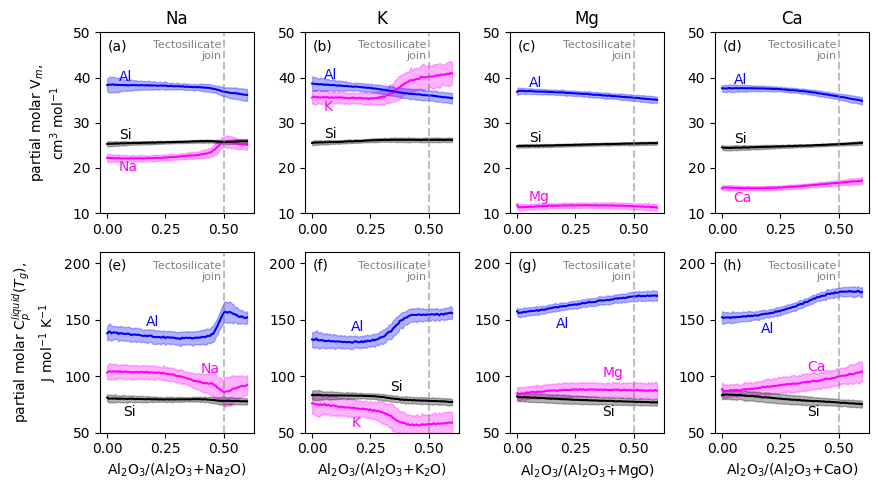

In [20]:
def subplots_Vm_Cpl(ax1, ax2, c_, v_, cpl_, tg_, cation="Na"):
    
    corresp = {"Na":2, "K":3, "Mg":4, "Ca":5}
    
    x_axis_values = c_[:,1]/(c_[:,1]+c_[:,corresp[cation]])
    
    ax1.plot(x_axis_values, v_[:,corresp[cation],:].mean(axis=-1), "-", color="magenta", alpha=1, label=cation)
    ax1.plot(x_axis_values, v_[:,1,:].mean(axis=-1),"b-", alpha=1, label="Al")
    ax1.plot(x_axis_values, v_[:,0,:].mean(axis=-1),"-", color="k", alpha=1, label="Si")
    
    ax1.fill_between(x_axis_values, 
                 v_[:,corresp[cation],:].mean(axis=-1)-2*v_[:,corresp[cation],:].std(axis=-1),
                 v_[:,corresp[cation],:].mean(axis=-1)+2*v_[:,corresp[cation],:].std(axis=-1),
                 color="magenta", alpha=0.3, label=cation)

    ax1.fill_between(x_axis_values, 
                     v_[:,1,:].mean(axis=-1)-2*v_[:,1,:].std(axis=-1),
                     v_[:,1,:].mean(axis=-1)+2*v_[:,1,:].std(axis=-1),
                     color="b", alpha=0.3, label="Al")

    ax1.fill_between(x_axis_values, 
                     v_[:,0,:].mean(axis=-1)-2*v_[:,0,:].std(axis=-1),
                     v_[:,0,:].mean(axis=-1)+2*v_[:,0,:].std(axis=-1),
                     color="k", alpha=0.3, label="Si")
    
    ax1.annotate("Si", xy=(0.05, v_[0,0,:].mean()+1), xycoords="data", color="black")
    ax1.annotate("Al", xy=(0.05, v_[0,1,:].mean()+1), xycoords="data", color="blue")
    
    if cation == "Mg":
        ax1.annotate(cation, xy=(0.05, v_[0,corresp[cation],:].mean()+1), xycoords="data", color="magenta")
    else:
        ax1.annotate(cation, xy=(0.05, v_[0,corresp[cation],:].mean()-3), xycoords="data", color="magenta")
    
    # HEAT CAPACITY
    cpl_tg_al2o3 = cpl_[:,1,:] + cpl_[:,6,:]*tg_
    
    # plot values
    ax2.plot(x_axis_values, cpl_[:,corresp[cation],:].mean(axis=-1),"-", color="magenta", alpha=1) # sodium
    ax2.plot(x_axis_values, cpl_tg_al2o3.mean(axis=-1),"b-", alpha=1) # Al
    ax2.plot(x_axis_values, cpl_[:,0,:].mean(axis=-1),"-", color="k", alpha=1) # Si

    ax2.fill_between(x_axis_values, 
                     cpl_[:,corresp[cation],:].mean(axis=-1)-2*cpl_[:,corresp[cation],:].std(axis=-1),
                     cpl_[:,corresp[cation],:].mean(axis=-1)+2*cpl_[:,corresp[cation],:].std(axis=-1),
                     color="magenta", alpha=0.3, label=cation)

    ax2.fill_between(x_axis_values, 
                     cpl_tg_al2o3.mean(axis=-1)-cpl_tg_al2o3.std(axis=-1),
                     cpl_tg_al2o3.mean(axis=-1)+cpl_tg_al2o3.std(axis=-1),
                     color="b", alpha=0.3, label="Al")

    ax2.fill_between(x_axis_values, 
                     cpl_[:,0,:].mean(axis=-1)-2*cpl_[:,0,:].std(axis=-1),
                     cpl_[:,0,:].mean(axis=-1)+2*cpl_[:,0,:].std(axis=-1),
                     color="k", alpha=0.3, label="Si")
    
    #ax2.annotate("Si", xy=(0.05, cpl_[0,0,:].mean()-10), xycoords="data", color="black")
    #ax2.annotate("Al", xy=(0.05, v_[0,1,:].mean()+1), xycoords="data", color="blue")
    #ax2.annotate(cation, xy=(0.05, v_[0,corresp[cation],:].mean()+1), xycoords="data", color="magenta")
    
    if (cation == "Na") or (cation=="K"):
        ax2.set_xlabel("Al$_2$O$_3$/(Al$_2$O$_3$+{}$_2$O)".format(cation))
    else:
        ax2.set_xlabel("Al$_2$O$_3$/(Al$_2$O$_3$+{}O)".format(cation))


plt.figure(figsize=(16/9*5,5))
ax1 = plt.subplot(2,4,1)
ax2 = plt.subplot(2,4,5)
ax3 = plt.subplot(2,4,2)
ax4 = plt.subplot(2,4,6)
ax5 = plt.subplot(2,4,3)
ax6 = plt.subplot(2,4,7)
ax7 = plt.subplot(2,4,4)
ax8 = plt.subplot(2,4,8)

subplots_Vm_Cpl(ax1, ax2, c_na, v_na, cpl_na, tg_na, cation="Na")
subplots_Vm_Cpl(ax3, ax4, c_k, v_k, cpl_k, tg_k, cation="K")
subplots_Vm_Cpl(ax5, ax6, c_mg, v_mg, cpl_mg, tg_mg, cation="Mg")
subplots_Vm_Cpl(ax7, ax8, c_ca, v_ca, cpl_ca, tg_ca, cation="Ca")

# add letters for each subplots
ax1.annotate("(a)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax2.annotate("(e)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax3.annotate("(b)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax4.annotate("(f)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax5.annotate("(c)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax6.annotate("(g)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax7.annotate("(d)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)
ax8.annotate("(h)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=10)

# add titles above relevant subplots
ax1.set_title("Na")
ax3.set_title("K")
ax5.set_title("Mg")
ax7.set_title("Ca")

# add axis labels
ax1.set_ylabel("partial molar V$_m$,\ncm$^3$ mol$^{-1}$")
ax2.set_ylabel("partial molar C$_p^{liquid}$($T_g$),\nJ mol$^{-1}$ K$^{-1}$")

# set limits for Y axis


# put the tectosilicate join
for i in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    i.axvline(0.5, color="grey", linestyle="--", alpha=0.5)
    
for i in [ax1,ax3,ax5,ax7]:
    i.set_ylim(10, 50)
    i.annotate("Tectosilicate\njoin", xy=(0.49, 44), xycoords="data", ha="right", fontsize=8, color="grey")
for i in [ax2, ax4, ax6, ax8]:
    i.set_ylim(50, 210)
    i.annotate("Tectosilicate\njoin", xy=(0.49, 185), xycoords="data", ha="right", fontsize=8, color="grey")

# add annotation for the elements for Cpl manually
ax2.annotate("Si", xy=(0.15, 0.09), xycoords="axes fraction", color="black")
ax4.annotate("Si", xy=(0.55, 0.23), xycoords="axes fraction", color="black")
ax6.annotate("Si", xy=(0.6, 0.09), xycoords="axes fraction", color="black")
ax8.annotate("Si", xy=(0.6, 0.09), xycoords="axes fraction", color="black")

ax2.annotate("Al", xy=(0.3, 0.59), xycoords="axes fraction", color="blue")
ax4.annotate("Al", xy=(0.3, 0.56), xycoords="axes fraction", color="blue")
ax6.annotate("Al", xy=(0.3, 0.58), xycoords="axes fraction", color="blue")
ax8.annotate("Al", xy=(0.3, 0.55), xycoords="axes fraction", color="blue")

ax2.annotate("Na", xy=(0.65, 0.33), xycoords="axes fraction", color="magenta")
ax4.annotate("K", xy=(0.3, 0.03), xycoords="axes fraction", color="magenta")
ax6.annotate("Mg", xy=(0.6, 0.31), xycoords="axes fraction", color="magenta")
ax8.annotate("Ca", xy=(0.6, 0.34), xycoords="axes fraction", color="magenta")

# annotate those lines
plt.tight_layout()
plt.savefig("./figures/manuscript/Figure9.pdf")


# Correlation with Al in CN 5 and 6

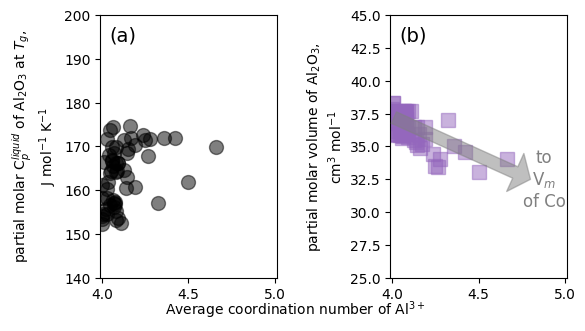

In [21]:
# We load the data
db_Al5_Ca = pd.read_excel("./data/Database.xlsx", sheet_name="CN_Al")
X_db_Al5_Ca = utils.descriptors(db_Al5_Ca.loc[:,["sio2", "al2o3", "na2o", "k2o", "mgo","cao"]]/100)
y_db_Al5_Ca = db_Al5_Ca.loc[:,["Al5"]].values
y_db_Al6_Ca = db_Al5_Ca.loc[:,["Al6"]].values
mean_db_Al_CN = (4*db_Al5_Ca.loc[:,["Al4"]].values/100
                +5*db_Al5_Ca.loc[:,["Al5"]].values/100
                +6*db_Al5_Ca.loc[:,["Al6"]].values/100)

# we predict the partial cpl for those compositions
partial_cpl_Al5_Ca = neuralmodel.predict("partial_cpl", X_db_Al5_Ca.values, sampling=True, n_sample=100)

# we also predict the partial molar volumes
partial_vm_Al5_Ca = neuralmodel.predict("vm_glass", X_db_Al5_Ca.values, sampling=True, n_sample=100)

# we calculate the Tg of the glasses
Tg_Al5_Ca = neuralmodel.predict("tg", X_db_Al5_Ca.values, sampling=True, n_sample=100)

# we calculate here the partial molar Cpl of Al2O3 at Tg
partial_cpl_Al2O3_Al5_Ca = partial_cpl_Al5_Ca[:,1,:] + partial_cpl_Al5_Ca[:,6,:]*Tg_Al5_Ca


# now we plot the fraction of Al5 in the glass
# against the partial cpl of Al2O3 at Tg
fig = plt.figure(figsize=(6,3.22))
ax1 = plt.subplot(1,2,1)
plt.plot(mean_db_Al_CN, partial_cpl_Al2O3_Al5_Ca.mean(axis=-1), "ko", ms=10, alpha=0.5)

plt.xlim(3.99,5.01)
plt.ylim(140,200)
plt.ylabel("partial molar C$_p^{liquid}$ of Al$_2$O$_3$ at $T_g$,\nJ mol$^{-1}$ K$^{-1}$")

plt.annotate("(a)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=14)

ax2 = plt.subplot(1,2,2)
plt.plot(mean_db_Al_CN, partial_vm_Al5_Ca[:,1,:].mean(axis=-1), "s", ms=10, color="C4", alpha=0.5)

plt.annotate("", xy=(4.8, 32.5), xytext=(4.01, 37.2), xycoords="data",
             arrowprops=dict(linestyle="-", 
                             width = 9, headwidth=30, 
                             color="grey", alpha=0.5), 
             va="center", ha="left")

plt.annotate("to\nV$_m$\nof Co", xy=(4.88, 32.5), xycoords="data", color="grey", 
             ha="center", va="center", fontsize=12)

plt.xlim(3.99,5.01)
plt.ylim(25,45)

plt.annotate("(b)", xy=(0.05, 0.9), xycoords="axes fraction", fontsize=14)

fig.text(x=0.5,y=0.005,s="Average coordination number of Al$^{3+}$", ha="center")
plt.ylabel("partial molar volume of Al$_2$O$_3$,\ncm$^3$ mol$^{-1}$")

plt.tight_layout()
plt.savefig("./figures/manuscript/Figure10.pdf")
